# Native contacts calculation

The aim of this script is to 
i) Calculate the native contacts of each frame for every simulation 
ii) Visualise the results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import pandas as pd

In [2]:
pdb = "Fab.pdb"
xtc = "loop3_r5_277_3_5_150M_md_0_1.xtc"

In [3]:
u = mda.Universe(pdb,xtc)

In [4]:
print(u)
print(len(u.trajectory))
print(u.residues)

<Universe with 6598 atoms>
1001
<ResidueGroup [<Residue ASP, 1>, <Residue ILE, 2>, <Residue GLN, 3>, ..., <Residue SER, 440>, <Residue ALA, 441>, <Residue ALA, 442>]>


In [60]:
for atom in u.select_atoms('resname ASP or resname GLU'):
    print(atom)

<Atom 1: N of type N of resname ASP, resid 1 and segid A and altLoc >
<Atom 2: CA of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 3: C of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 4: O of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 5: CB of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 6: CG of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 7: OD1 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 8: OD2 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 9: 1H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 10: 2H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 11: 3H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 12: HA of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 13: 1HB of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 14: 2HB of type H of resname ASP, resid 1 and segid A and altLoc >


In [62]:
# # Just to check whether there're any atoms extracted. 
# # As you can see in the results, the atoms here are not null. So it worked.

# acidic = u.select_atoms("(resname ASP GLU) and (name OE* OD*)")
# acidic

<AtomGroup with 62 atoms>

In [64]:
# the reason as the above

# basic = u.select_atoms("(resname ARG LYS) and (name N)")
# basic

<AtomGroup with 38 atoms>

In [5]:
# A more efficient way to do the same thing as the two lines above

sel_basic = "(resname ARG LYS) and (name N)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"

acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

display(acidic)
display(basic)

<AtomGroup with 62 atoms>

<AtomGroup with 38 atoms>

In [22]:
print(basic)

<AtomGroup [<Atom 232: N of type N of resname ARG, resid 18 and segid A and altLoc >, <Atom 329: N of type N of resname LYS, resid 24 and segid A and altLoc >, <Atom 419: N of type N of resname ARG, resid 30 and segid A and altLoc >, ..., <Atom 6378: N of type N of resname LYS, resid 428 and segid B and altLoc >, <Atom 6445: N of type N of resname LYS, resid 432 and segid B and altLoc >, <Atom 6500: N of type N of resname LYS, resid 436 and segid B and altLoc >]>


There are some problems with the codes above. The acidic atoms and basic atoms should be the same isn't it???

### ca1 native contacts calculation - Hard cutoff with a single reference

In [71]:
# This is ca1 native contacts calculation

# set up analysis of native contacts ("salt bridges"); salt bridges have a
# distance <6 A
ca1 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=7.0)
# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()
# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))

average contacts = 0.37217684276507806


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


# plot time series q(t)
fig, ax = plt.subplots()
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

### Radius cutoff

In [74]:
ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 70 but corresponding boolean dimension is 62

### Soft cutoff


In [8]:
ref = u

ref.trajectory[-1]
acidic_2 = ref.select_atoms(sel_acidic)
basic_2 = ref.select_atoms(sel_basic)

In [12]:
print(ref.trajectory[-1])

< Timestep 1000 with unit cell dimensions [108.95402 108.95402 108.95402  90.       90.       90.     ] >


In [9]:
print(len(sel_acidic))
print(len(sel_basic))

36
30


In [10]:
print(len(acidic_2), len(basic_2))
print(len(acidic_2.select_atoms(sel_acidic)), len(basic_2.select_atoms(sel_basic)))

62 38
62 38


In [77]:

ca3 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=[(acidic, basic), (acidic_2, basic_2)],
                        radius=4.5,
                        method='soft_cut',
                        kwargs={'beta': 5.0,
                                'lambda_constant': 1.5}).run()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 70 but corresponding boolean dimension is 62

### Two-dimensional contact analysis

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

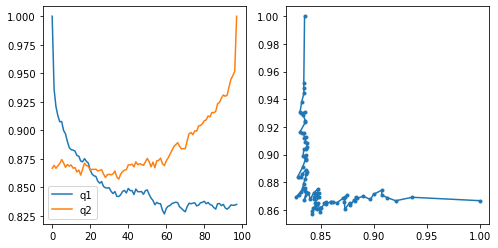

In [75]:
q1q2 = contacts.q1q2(u, 'all', radius=8)
q1q2.run()

f, ax = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 1], label='q1')
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 2], label='q2')
ax[0].legend(loc='best')
ax[1].plot(q1q2.timeseries[:, 1], q1q2.timeseries[:, 2], '.-')
f.show()

To be honest though, I have no idea how to interpret this plot. Still need to read tutorials & check papers though.

## Test for checking the naming rules in xtc files and dcd files

THe whole purpose for this section is to check the N atom along with all the other atoms, how they are names. All this can be traced back to one problem observed - when I use command u.select_atoms("(resname ARG or resname LYS) and (name NH* NZ)it doesnt' return back any atom. 

So it is important to know that what are the namings here. If they are in different formats.

In [35]:
pdb2 = "Fab.pdb"
xtc2 = "loop3_r5_277_3_5_150M_md_0_1.xtc"

In [25]:
# example trajectory (transition of AdK from closed to open)
u = mda.Universe(pdb, xtc)

In [36]:
u2 = mda.Universe(pdb2, xtc2)

In [4]:
print(u)
print(len(u.trajectory))
print(u.residues)

<Universe with 1770 atoms>
501
<ResidueGroup [<Residue ASP, 1>, <Residue ILE, 2>, <Residue GLN, 3>, ..., <Residue SER, 440>, <Residue ALA, 441>, <Residue ALA, 442>]>


In [26]:
print(u.select_atoms('resname ASP or resname GLU'))

<AtomGroup [<Atom 1: N of type N of resname ASP, resid 1 and segid SYSTEM and altLoc >, <Atom 2: CA of type C of resname ASP, resid 1 and segid SYSTEM and altLoc >, <Atom 3: C of type C of resname ASP, resid 1 and segid SYSTEM and altLoc >, ..., <Atom 1739: CA of type C of resname ASP, resid 435 and segid SYSTEM and altLoc >, <Atom 1740: C of type C of resname ASP, resid 435 and segid SYSTEM and altLoc >, <Atom 1741: O of type O of resname ASP, resid 435 and segid SYSTEM and altLoc >]>


In [37]:
for atom in u2.select_atoms('resname ASP or resname GLU'):
    print(atom)

<Atom 1: N of type N of resname ASP, resid 1 and segid A and altLoc >
<Atom 2: CA of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 3: C of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 4: O of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 5: CB of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 6: CG of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 7: OD1 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 8: OD2 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 9: 1H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 10: 2H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 11: 3H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 12: HA of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 13: 1HB of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 14: 2HB of type H of resname ASP, resid 1 and segid A and altLoc >


#### Update 8/6/23, To note here, the DCD file was converted by MDanalysis package which was not great. The DCD file size was not even correct. So should try it again with the right size DCD file

In [45]:
ag = u2.select_atoms('all')
ag.write("loop3_r5_277_3_5_150M_md_0_1.dcd")

In [46]:
dcd = "loop3_r5_277_3_5_150M_md_0_1.dcd"

In [47]:
u3 = mda.Universe(pdb2, dcd)

In [48]:
for atom in u3.select_atoms('resname ASP or resname GLU'):
    print(atom)

<Atom 1: N of type N of resname ASP, resid 1 and segid A and altLoc >
<Atom 2: CA of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 3: C of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 4: O of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 5: CB of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 6: CG of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 7: OD1 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 8: OD2 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 9: 1H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 10: 2H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 11: 3H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 12: HA of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 13: 1HB of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 14: 2HB of type H of resname ASP, resid 1 and segid A and altLoc >


In [38]:
AG = u.select_atoms('resname ASP or resname GLU')

In [29]:
AG

<AtomGroup with 124 atoms>

In [27]:
print(u.select_atoms('name NH* NZ'))

<AtomGroup []>


In [50]:
print(u.select_atoms("(resname ARG or resname LYS) and (name NH* NZ)"))

<AtomGroup []>


In [7]:
u.atoms

<AtomGroup with 1770 atoms>

In [51]:
# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.

# As the comments above, perhaps need to double check whether use this version of defination of salt bridges

# this defination doesnt work in this case

sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

In [52]:
print(acidic)
print(basic)

<AtomGroup []>
<AtomGroup []>


In [53]:
# set up analysis of native contacts ("salt bridges"); salt bridges have a
# distance <6 A
ca1 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=6.0)
# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()

# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))

average contacts = nan


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:296: RuntimeWarning: invalid value encountered in long_scalars
  return y.sum() / r.size
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


/var/folders/mt/ltbxwyxj5xj9wqq31r2q687r0000gn/T/ipykernel_47884/3108943819.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


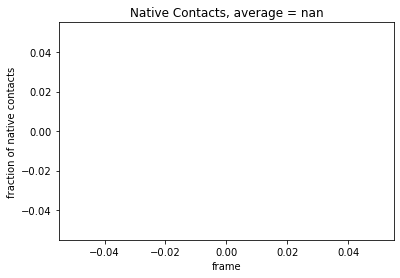

In [54]:
# plot time series q(t)
fig, ax = plt.subplots()
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

## Test with example 

In [28]:

import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import contacts

import nglview as nv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

average contacts = 0.48137507430156534


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/var/folders/mt/ltbxwyxj5xj9wqq31r2q687r0000gn/T/ipykernel_3340/3572857328.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non

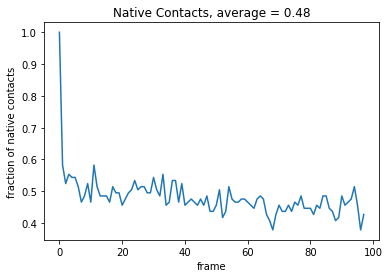

In [29]:
u = mda.Universe(PSF,DCD)
# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
# reference groups (first frame of the trajectory, but you could also use a
# separate PDB, eg crystal structure)
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)
# set up analysis of native contacts ("salt bridges"); salt bridges have a
# distance <6 A
ca1 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=6.0)
# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()
# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))
# plot time series q(t)
fig, ax = plt.subplots()
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

In [7]:
sel_basic

'(resname ARG LYS) and (name NH* NZ)'

In [30]:
acidic 

<AtomGroup with 70 atoms>

In [31]:
basic

<AtomGroup with 44 atoms>

#### Okay, no worries. You see here? The acidic group and basic group do not have the same numbers. This makes sense. Because not necessarily every atom has the same amount of charge attached to them. So the error in 2.0.2 is nothing to do with the different number between the acidic and basic group.

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

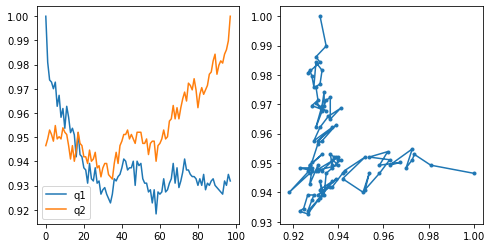

In [73]:
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
from MDAnalysisTests.datafiles import PSF, DCD
u = mda.Universe(PSF, DCD)
q1q2 = contacts.q1q2(u, 'name CA', radius=8)
q1q2.run()

f, ax = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 1], label='q1')
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 2], label='q2')
ax[0].legend(loc='best')
ax[1].plot(q1q2.timeseries[:, 1], q1q2.timeseries[:, 2], '.-')
f.show()

In [15]:
ref = mda.Universe(PSF, DCD)

ref.trajectory[-1]
acidic_2 = ref.select_atoms(sel_acidic)
basic_2 = ref.select_atoms(sel_basic)

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [17]:
print(sel_acidic)
print(sel_basic)

(resname ASP GLU) and (name OE* OD*)
(resname ARG LYS) and (name N)


In [18]:
print(acidic_2)
print(basic_2)

<AtomGroup [<Atom 329: OE1 of type 72 of resname GLU, resid 22 and segid 4AKE>, <Atom 330: OE2 of type 72 of resname GLU, resid 22 and segid 4AKE>, <Atom 492: OD1 of type 72 of resname ASP, resid 33 and segid 4AKE>, ..., <Atom 3237: OD2 of type 72 of resname ASP, resid 208 and segid 4AKE>, <Atom 3270: OE1 of type 72 of resname GLU, resid 210 and segid 4AKE>, <Atom 3271: OE2 of type 72 of resname GLU, resid 210 and segid 4AKE>]>
<AtomGroup [<Atom 20: N of type 54 of resname ARG, resid 2 and segid 4AKE>, <Atom 175: N of type 54 of resname LYS, resid 13 and segid 4AKE>, <Atom 333: N of type 54 of resname LYS, resid 23 and segid 4AKE>, ..., <Atom 3101: N of type 54 of resname LYS, resid 200 and segid 4AKE>, <Atom 3194: N of type 54 of resname ARG, resid 206 and segid 4AKE>, <Atom 3274: N of type 54 of resname LYS, resid 211 and segid 4AKE>]>


In [20]:
display(acidic_2)
display(acidic_2)

<AtomGroup with 70 atoms>

<AtomGroup with 70 atoms>

# Native contact with DCD file

The rationale here is that, previously with MDanalysis package, it is noticed that the package does not deal with XTC file well enough to calculate its native contacts. The location of N atoms are not specified in the XTC file which caused trouble for the package to proceed the native contact calculation.

To solve this problem, several methods are tried:
i) try to convert XTC to DCD and see if the information has been retrieved.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import os

In [3]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423'

In [7]:
os.chdir('/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/TestOneDCD080623')

In [8]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/TestOneDCD080623'

In [9]:
ls

4_5_338_50_r5_md_0_1.dcd  4_5_338_50_r5_md_0_1.xtc


In [32]:
pdb = "Fab.pdb"
dcd = "4_5_338_50_r5_md_0_1.dcd"

In [33]:
u = mda.Universe(pdb,dcd)

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [12]:
print(u)
print(len(u.trajectory))
print(u.residues)

<Universe with 6598 atoms>
1001
<ResidueGroup [<Residue ASP, 1>, <Residue ILE, 2>, <Residue GLN, 3>, ..., <Residue SER, 440>, <Residue ALA, 441>, <Residue ALA, 442>]>


In [13]:
for atom in u.select_atoms('resname ASP or resname GLU'):
    print(atom)

<Atom 1: N of type N of resname ASP, resid 1 and segid A and altLoc >
<Atom 2: CA of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 3: C of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 4: O of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 5: CB of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 6: CG of type C of resname ASP, resid 1 and segid A and altLoc >
<Atom 7: OD1 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 8: OD2 of type O of resname ASP, resid 1 and segid A and altLoc >
<Atom 9: 1H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 10: 2H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 11: 3H of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 12: HA of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 13: 1HB of type H of resname ASP, resid 1 and segid A and altLoc >
<Atom 14: 2HB of type H of resname ASP, resid 1 and segid A and altLoc >


In [14]:
AG = u.select_atoms('resname ASP or resname GLU')

In [19]:
AG

<AtomGroup with 421 atoms>

##### Look here, the DCD file retrieved the positions of N atoms

In [16]:
# Find the N atoms that could comprise native contacts

print(u.select_atoms('name NH* NZ'))


<AtomGroup [<Atom 241: NH1 of type N of resname ARG, resid 18 and segid A and altLoc >, <Atom 242: NH2 of type N of resname ARG, resid 18 and segid A and altLoc >, <Atom 337: NZ of type N of resname LYS, resid 24 and segid A and altLoc >, ..., <Atom 6386: NZ of type N of resname LYS, resid 428 and segid B and altLoc >, <Atom 6453: NZ of type N of resname LYS, resid 432 and segid B and altLoc >, <Atom 6508: NZ of type N of resname LYS, resid 436 and segid B and altLoc >]>


In [26]:
# Find the N atoms in ARG or LYS that could comprise native contacts

print(u.select_atoms("(resname ARG or resname LYS) and (name NH* NZ)"))
display(u.select_atoms("(resname ARG or resname LYS) and (name NH* NZ)"))

<AtomGroup [<Atom 241: NH1 of type N of resname ARG, resid 18 and segid A and altLoc >, <Atom 242: NH2 of type N of resname ARG, resid 18 and segid A and altLoc >, <Atom 337: NZ of type N of resname LYS, resid 24 and segid A and altLoc >, ..., <Atom 6386: NZ of type N of resname LYS, resid 428 and segid B and altLoc >, <Atom 6453: NZ of type N of resname LYS, resid 432 and segid B and altLoc >, <Atom 6508: NZ of type N of resname LYS, resid 436 and segid B and altLoc >]>


<AtomGroup with 50 atoms>

In [25]:
print(u.select_atoms("(resname ASP or resname GLU) and (name OE* OD*)"))
display(u.select_atoms("(resname ASP or resname GLU) and (name OE* OD*)"))

<AtomGroup [<Atom 7: OD1 of type O of resname ASP, resid 1 and segid A and altLoc >, <Atom 8: OD2 of type O of resname ASP, resid 1 and segid A and altLoc >, <Atom 226: OD1 of type O of resname ASP, resid 17 and segid A and altLoc >, ..., <Atom 6424: OE2 of type O of resname GLU, resid 430 and segid B and altLoc >, <Atom 6494: OD1 of type O of resname ASP, resid 435 and segid B and altLoc >, <Atom 6495: OD2 of type O of resname ASP, resid 435 and segid B and altLoc >]>


<AtomGroup with 62 atoms>

In [34]:
# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.

#reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

# As the comments above, perhaps need to double check whether use this version of defination of salt bridges

# this defination doesn't work in this case

sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

#the (acidic, basic) selections from u, which are assigned from the first frame 

basic = u.select_atoms(sel_basic)
acidic = u.select_atoms(sel_acidic)


display(basic)
display(acidic)

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

Hmmmm... Is it possible for the basic and acidic numbers not the same...?
- Yes!
- The acidic group and basic group do not have the same numbers. This makes sense. Because not necessarily every atom has the same amount of charge attached to them. So the error in 2.0.2 is nothing to do with the different number between the acidic and basic group.

average contacts = 0.14135864135864135


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/var/folders/mt/ltbxwyxj5xj9wqq31r2q687r0000gn/T/ipykernel_3340/2332944912.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


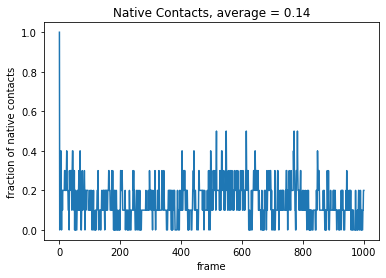

In [35]:
# set up analysis of native contacts ("salt bridges"); salt bridges have a
# distance <4.5 A

ca1 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=4.5)

# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()

# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))

# plot time series q(t)
fig, ax = plt.subplots()
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

## Trying to find out the above codes are hard cutoff or radius

### Hard cutoff with a single reference

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Fraction of contacts')

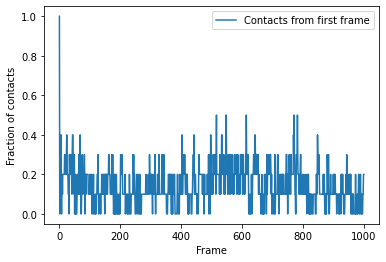

In [36]:
#Hard cutoff with a single reference

ca_h = contacts.Contacts(u,
                        select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='hard_cut').run()

ca_h_df = pd.DataFrame(ca1.timeseries,
                      columns=['Frame',
                               'Contacts from first frame'])
ca_h_df.head()

ca_h_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

### Radius cutoff


average contacts = 0.29920079920079923


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Fraction of contacts')

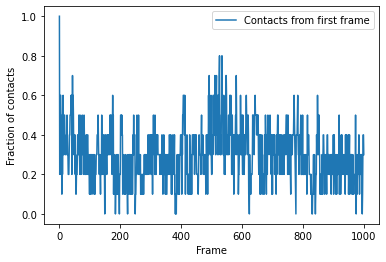

In [38]:
ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

# print number of averave contacts
average_contacts = np.mean(ca2.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))


ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

# Test try with the four DCD files 

13/06/23
The main purpose of this section is to see whether the five DCD files converted from XTC with VMD are the same or not, since previously with DCCM plots there was such issue: all the DCCM plots were exactly the same.

As a note, the below files are used:
3_5_277_0_r4_md_0_1.dcd - convert with VMD manually using buttons
4_5_338_50_r5_md_0_1.dcd - all else were generated in the TK console
8_338_400_r6_md_0_1.dcd
8_338_500_r1_md_0_1.dcd


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import os

In [2]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423'

In [2]:
os.chdir('/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/ConvertDCD5Test110623')

In [4]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/ConvertDCD5Test110623'

In [5]:
ls

3_5_277_0_r4_md_0_1.dcd   8_338_400_r5_md_0_1.xtc   8_338_500_r1_md_0_1.xtc
3_5_277_0_r4_md_0_1.xtc   8_338_400_r6_md_0_1.dcd   Fab.pdb
4_5_338_50_r5_md_0_1.dcd  8_338_400_r6_md_0_1.xtc
4_5_338_50_r5_md_0_1.xtc  8_338_500_r1_md_0_1.dcd


### 3_5_277_0_r4_md_0_1.dcd

In [3]:
pdb = "Fab.pdb"
dcd = "3_5_277_0_r4_md_0_1.dcd"
u = mda.Universe(pdb,dcd)

print(u)
print(len(u.trajectory))
print(u.residues)

<Universe with 6598 atoms>
1002
<ResidueGroup [<Residue ASP, 1>, <Residue ILE, 2>, <Residue GLN, 3>, ..., <Residue SER, 440>, <Residue ALA, 441>, <Residue ALA, 442>]>


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [6]:
display(u.trajectory)
u.trajectory

<DCDReader 3_5_277_0_r4_md_0_1.dcd with 1002 frames of 6598 atoms>

<DCDReader 3_5_277_0_r4_md_0_1.dcd with 1002 frames of 6598 atoms>

In [7]:
# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.

#reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

# As the comments above, perhaps need to double check whether use this version of defination of salt bridges

# this defination doesn't work in this case

sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

#the (acidic, basic) selections from u, which are assigned from the first frame 

basic = u.select_atoms(sel_basic)
acidic = u.select_atoms(sel_acidic)


display(basic)
display(acidic)

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

average contacts = 0.09331337325349301


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Fraction of contacts')

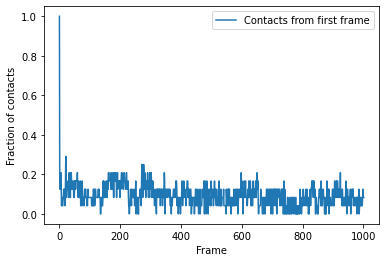

In [10]:
ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

# print number of averave contacts
average_contacts = np.mean(ca2.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))


ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

### 4_5_338_50_r5_md_0_1.dcd

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

average contacts = 0.10853293413173652


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Fraction of contacts')

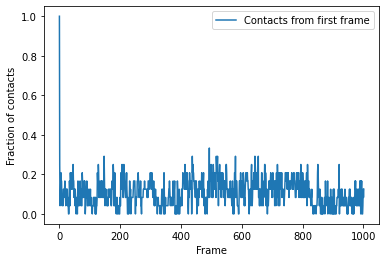

In [11]:
pdb = "Fab.pdb"
dcd = "4_5_338_50_r5_md_0_1.dcd"
u = mda.Universe(pdb,dcd)

# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.

#reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

# As the comments above, perhaps need to double check whether use this version of defination of salt bridges

# this defination doesn't work in this case

sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

#the (acidic, basic) selections from u, which are assigned from the first frame 

basic = u.select_atoms(sel_basic)
acidic = u.select_atoms(sel_acidic)


display(basic)
display(acidic)

ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

# print number of averave contacts
average_contacts = np.mean(ca2.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))


ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

### 8_338_400_r6_md_0_1.dcd

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

average contacts = 0.13323353293413173


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Fraction of contacts')

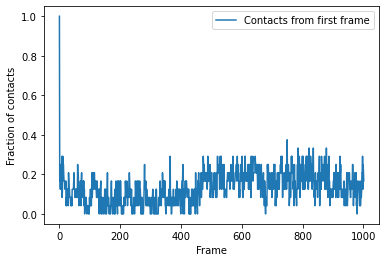

In [12]:
pdb = "Fab.pdb"
dcd = "8_338_400_r6_md_0_1.dcd"
u = mda.Universe(pdb,dcd)

# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.

#reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

# As the comments above, perhaps need to double check whether use this version of defination of salt bridges

# this defination doesn't work in this case

sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

#the (acidic, basic) selections from u, which are assigned from the first frame 

basic = u.select_atoms(sel_basic)
acidic = u.select_atoms(sel_acidic)


display(basic)
display(acidic)

ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

# print number of averave contacts
average_contacts = np.mean(ca2.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))


ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

### 8_338_500_r1_md_0_1.dcd

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

average contacts = 0.09930139720558882


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


Text(0, 0.5, 'Fraction of contacts')

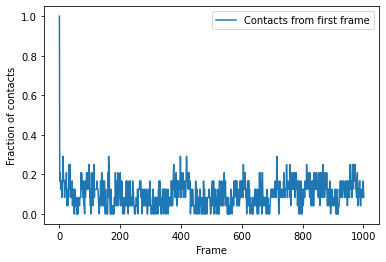

In [13]:
pdb = "Fab.pdb"
dcd = "8_338_500_r1_md_0_1.dcd"
u = mda.Universe(pdb,dcd)

# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.

#reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

# As the comments above, perhaps need to double check whether use this version of defination of salt bridges

# this defination doesn't work in this case

sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

#the (acidic, basic) selections from u, which are assigned from the first frame 

basic = u.select_atoms(sel_basic)
acidic = u.select_atoms(sel_acidic)


display(basic)
display(acidic)

ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

# print number of averave contacts
average_contacts = np.mean(ca2.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))


ca2_df.plot(x='Frame')
plt.ylabel('Fraction of contacts')

# Iterate over files for 54 conditions - 14/06/23

In [5]:
import os

In [1]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423'

In [10]:
# the path to the 54 DCD files
path = '/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/54DCD140623'

In [11]:
os.chdir(path)

In [12]:
path

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/54DCD140623'

In [13]:
# check the contents of a folder
for file in os.listdir(path):
    print(file)


9_338_100_r4_md_0_1.dcd
5_5_296_150_r6_md_0_1.dcd
8_338_500_r4_md_0_1.dcd
Loop1_277K_7_250M_md_0_1.dcd
4_5_338_100_r5_md_0_1.dcd
3_5_338_250_r1_md_0_1.dcd
5_5_296_50_r6_md_0_1.dcd
loop5_r5_318_4_5_150M_3_md_0_1.dcd
loop2_r4_338K_7_50M_md_0_1.dcd
9_338_200_r5_md_0_1.dcd
3_5_277_0_r3_md_0_1.dcd
7_296_150_r1_md_0_1.dcd
4_5_338_200_r4_md_0_1.dcd
8_338_200_r1_md_0_1.dcd
5_5_296_0_r4_md_0_1.dcd
4_5_296_250_r6_md_0_1.dcd
9_338_300_r2_md_0_1.dcd
loop6_r3_338_4_5_250M_md_0_1.dcd
3_5_277_50_r2_md_0_1.dcd
Loop6_318_4_5_50M_md_0_1.dcd
8_338_300_r6_md_0_1.dcd
8_277_100_r5_md_0_1.dcd
4_5_338_50_r1_md_0_1.dcd
loop3_r3_318_3_5_250M_md_0_1.dcd
5_5_296_100_r1_md_0_1.dcd
8_338_400_r3_md_0_1.dcd
Replicas_318_4_5_150M_4_r2_md_0_1.dcd
Loop1_r5_296K_7_50M_md_0_1.dcd
3_5_338_200_r6_md_0_1.dcd
7_296_50_r3_md_0_1.dcd
4_5_338_150_r2_md_0_1.dcd
loop4_r4_277_4_5_250M_md_0_1.dcd
3_5_338_100_r2_md_0_1.dcd
loop4_r1_296_4_5_50M_2_md_0_1.dcd
8_338_300_r3_md_0_1.dcd
loop5_r3_318_4_5_150M_md_0_1.dcd
4_5_296_250_r3_md_0_1

238

In [14]:
# count the number of files in a folder
# reference: https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python

files = os.listdir(path)
len(files)

325

In [7]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/54DCD140623'

In [18]:
pdb = "Fab.pdb"

for file in os.listdir(path):
    
    try:
        dcd = file
        u = mda.Universe(pdb,dcd)

        # crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
        # OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
        # problem before using this for real work.

        #reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

        # As the comments above, perhaps need to double check whether use this version of defination of salt bridges

        # this defination doesn't work in this case

        sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
        sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

        #the (acidic, basic) selections from u, which are assigned from the first frame 

        basic = u.select_atoms(sel_basic)
        acidic = u.select_atoms(sel_acidic)


        display(basic)
        display(acidic)

        ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

        ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

        # print number of averave contacts
        average_contacts = np.mean(ca2.timeseries[:, 1])
        print('average contacts = {}'.format(average_contacts))


        ca2_df.plot(x='Frame')
        plt.ylabel('Fraction of contacts')
        
    except:
        pass

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

<AtomGroup with 50 atoms>

<AtomGroup with 62 atoms>

## Test the loop with 5 DCD first 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import pandas as pd

In [19]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/54DCD140623'

In [20]:
os.chdir('/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/5DCDTest140623')

In [21]:
pwd

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/5DCDTest140623'

In [24]:
path = os.getcwd()
path

'/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/5DCDTest140623'

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r3_md_0_1 = 0.08599467731204258


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r1_md_0_1 = 0.051688290086493685


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r4_md_0_1 = 0.09331337325349301


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r2_md_0_1 = 0.08275116433799068


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


The average contacts of 3_5_277_0_r5_md_0_1 = 0.11119427811044577


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)


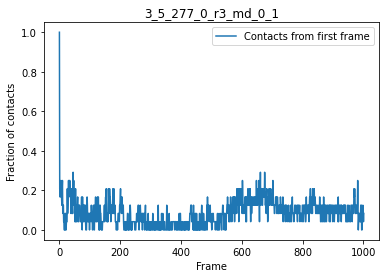

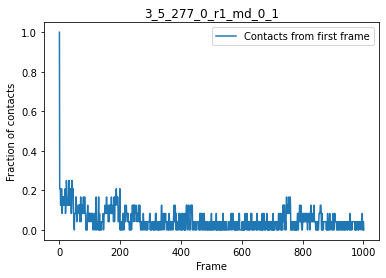

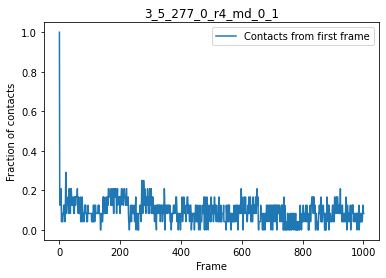

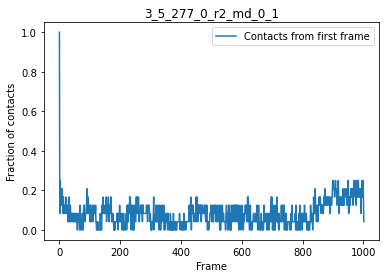

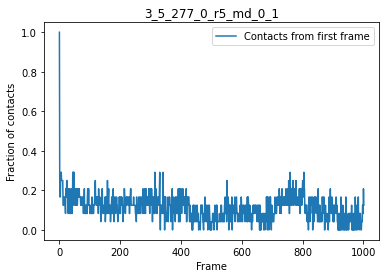

In [38]:
pdb = "Fab.pdb"

for file in os.listdir(path):
    
    # select the file that ends with .dcd
    # reference: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
    if file.endswith(".dcd"):

    
        dcd = file
        u = mda.Universe(pdb,dcd)

        # get the filename without the extension
        filename = os.path.splitext(file)[0]

        # crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
        # OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
        # problem before using this for real work.

        #reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

        # As the comments above, perhaps need to double check whether use this version of defination of salt bridges

        # this defination doesn't work in this case

        sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
        sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

        #the (acidic, basic) selections from u, which are assigned from the first frame 

        basic = u.select_atoms(sel_basic)
        acidic = u.select_atoms(sel_acidic)


        ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

        ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

        # print number of average contacts for each condition
        average_contacts = np.mean(ca2.timeseries[:, 1])

        print('The average contacts of {} = {}'.format(filename ,average_contacts))


        ca2_df.plot(x='Frame')
        plt.ylabel('Fraction of contacts')
        plt.title(filename)
        
        plt.savefig(filename + '.png')
        
        continue
    
    else:
        continue
      


In [39]:
ca2_df

Frame  Contacts from first frame
0        0.0                   1.000000
1        1.0                   0.250000
2        2.0                   0.166667
3        3.0                   0.166667
4        4.0                   0.250000
...      ...                        ...
997    997.0                   0.125000
998    998.0                   0.125000
999    999.0                   0.083333
1000  1000.0                   0.208333
1001  1001.0                   0.125000

[1002 rows x 2 columns]

In [42]:
# the last 50ns frames
# array

ca2.timeseries[501:, 1]

array([0.04166667, 0.04166667, 0.04166667, 0.08333333, 0.04166667,
       0.08333333, 0.08333333, 0.        , 0.04166667, 0.04166667,
       0.125     , 0.08333333, 0.08333333, 0.04166667, 0.08333333,
       0.125     , 0.04166667, 0.125     , 0.        , 0.08333333,
       0.04166667, 0.04166667, 0.04166667, 0.04166667, 0.04166667,
       0.04166667, 0.04166667, 0.08333333, 0.08333333, 0.04166667,
       0.125     , 0.125     , 0.125     , 0.04166667, 0.04166667,
       0.04166667, 0.08333333, 0.08333333, 0.04166667, 0.08333333,
       0.04166667, 0.04166667, 0.125     , 0.125     , 0.16666667,
       0.08333333, 0.08333333, 0.08333333, 0.125     , 0.04166667,
       0.25      , 0.16666667, 0.08333333, 0.125     , 0.16666667,
       0.125     , 0.        , 0.125     , 0.125     , 0.04166667,
       0.125     , 0.04166667, 0.04166667, 0.125     , 0.04166667,
       0.08333333, 0.16666667, 0.        , 0.04166667, 0.08333333,
       0.08333333, 0.125     , 0.125     , 0.125     , 0.08333

In [43]:
np.mean(ca2.timeseries[501:, 1])

0.09505988023952096

### Use this version - average native contacts is the last 50ns

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r3_md_0_1 = 0.10803393213572854


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r1_md_0_1 = 0.03592814371257485


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r4_md_0_1 = 0.07726214238190285


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r2_md_0_1 = 0.09264803725881568


/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

The average contacts of 3_5_277_0_r5_md_0_1 = 0.09505988023952096


Condition  Average native contact (last 50ns)
0  3_5_277_0_r3_md_0_1                            0.108034
1  3_5_277_0_r1_md_0_1                            0.035928
2  3_5_277_0_r4_md_0_1                            0.077262
3  3_5_277_0_r2_md_0_1                            0.092648
4  3_5_277_0_r5_md_0_1                            0.095060

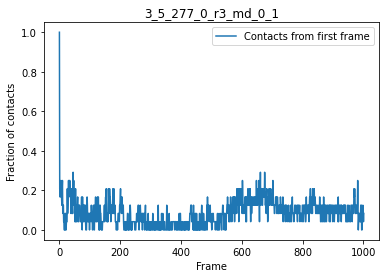

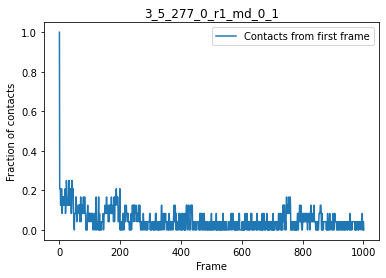

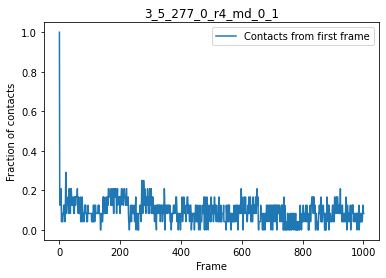

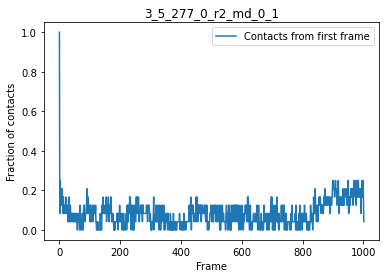

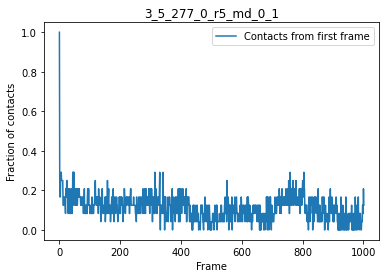

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import pandas as pd
import os

#Change to the five DCD files' directory

os.chdir('/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/5DCDTest140623')

# define directory
path = os.getcwd()


# read pdb
pdb = "Fab.pdb"

# create a list for saving average native contacts
data = []
cols = ['Condition', 'Average native contact (last 50ns)']

# loop over every dcd file in the directory
for file in os.listdir(path):
    
    # select the file that ends with .dcd
    # reference: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
    if file.endswith(".dcd"):

        #read dcd trajecotry
        dcd = file
        u = mda.Universe(pdb,dcd)

        # get the filename without the extension
        filename = os.path.splitext(file)[0]

        # crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
        # OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
        # problem before using this for real work.

        #reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

        # As the comments above, perhaps need to double check whether use this version of defination of salt bridges

        # this defination doesn't work in this case

        sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
        sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

        #the (acidic, basic) selections from u, which are assigned from the first frame 

        basic = u.select_atoms(sel_basic)
        acidic = u.select_atoms(sel_acidic)


        ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

        ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

        # print number of average contacts for each condition from the last 50ns
        average_contacts = np.mean(ca2.timeseries[501:, 1])
        
        # append the values into a list first and then convert it to a dataframe
        # this will save a lot of performance time
        # reference: https://stackoverflow.com/questions/31674557/how-to-append-rows-in-a-pandas-dataframe-in-a-for-loop
        data.append([filename ,average_contacts])

        print('The average contacts of {} = {}'.format(filename ,average_contacts))


        ca2_df.plot(x='Frame')
        plt.ylabel('Fraction of contacts')
        plt.title(filename)
        
        plt.savefig(filename + '.png')
        
        continue
    
    else:
        continue



In [49]:
df1 = pd.DataFrame(data, columns=cols)
df1.to_excel('5DCDTest140623.xlsx')

## Loop over 54 conditions

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDA

/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/analysis/contacts.py:509: DeprecationWarning: The `timeseries` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.timeseries` instead
  warnings.warn(wmsg, DeprecationWarning)
/Users/wintermute/opt/anaconda3/envs/mdanalysis/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanal

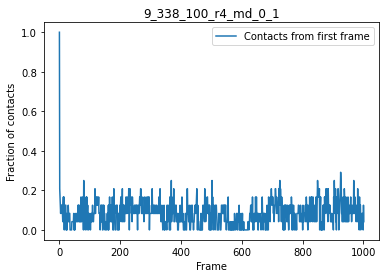

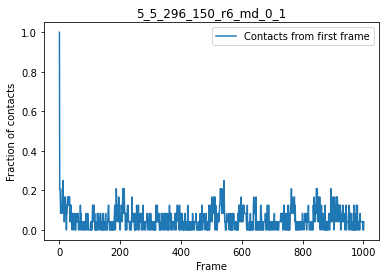

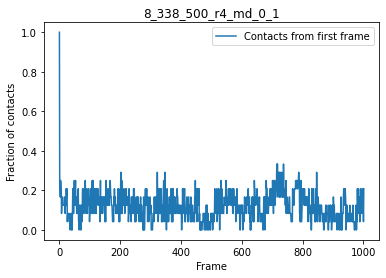

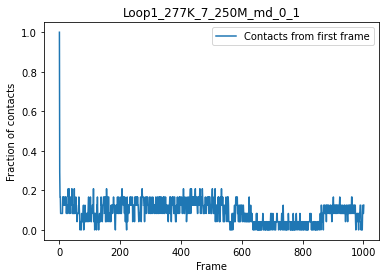

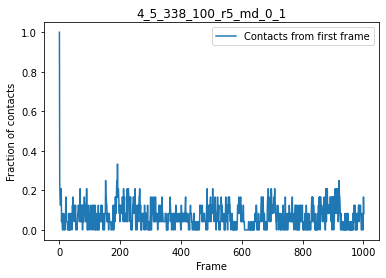

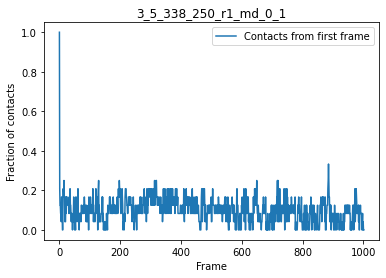

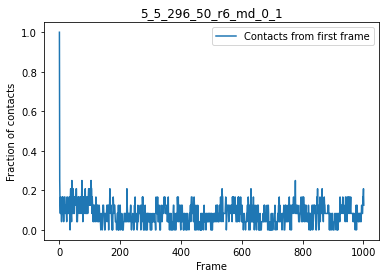

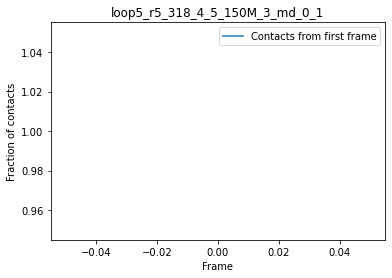

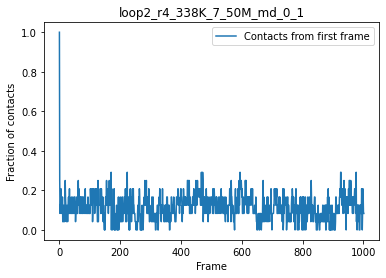

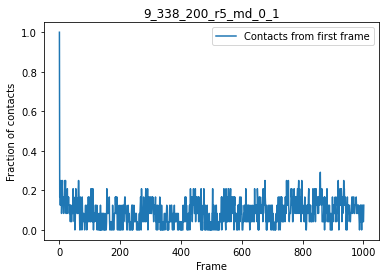

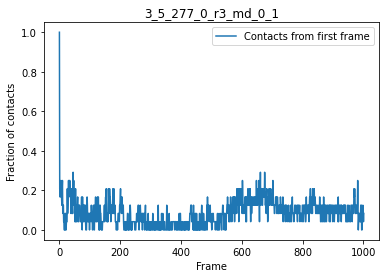

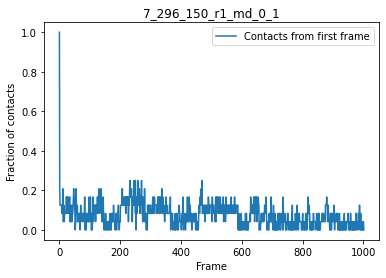

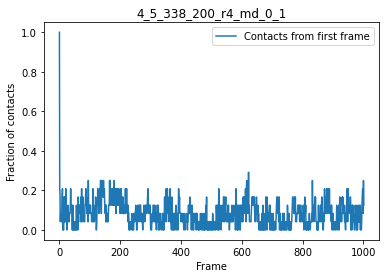

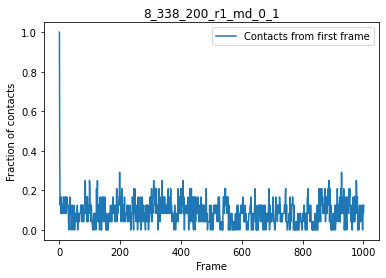

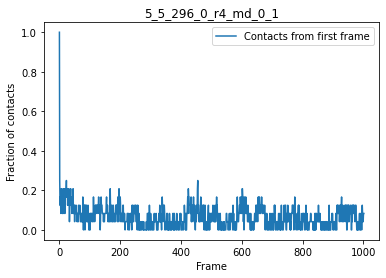

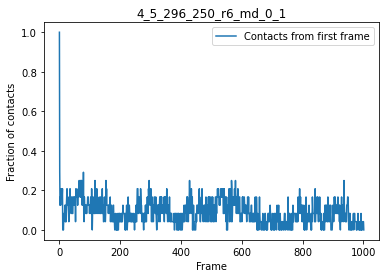

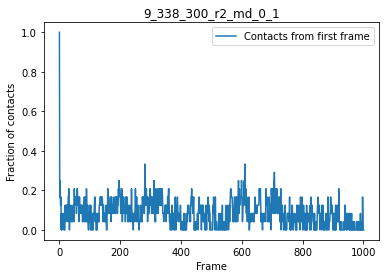

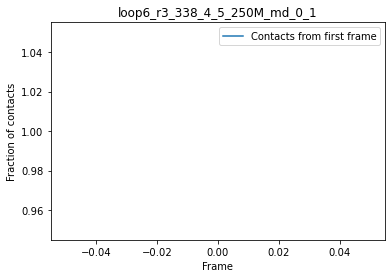

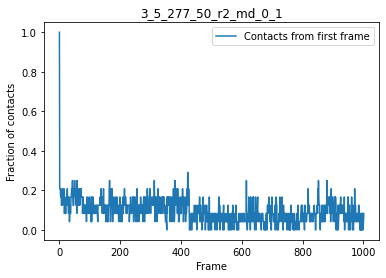

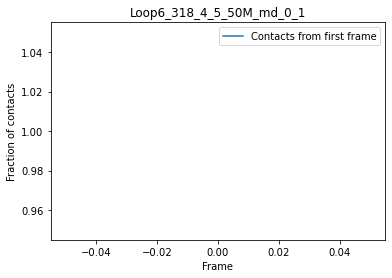

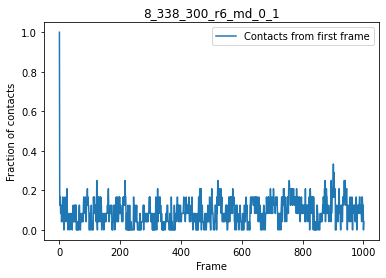

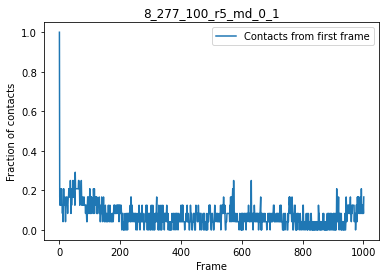

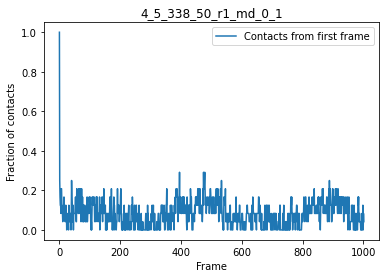

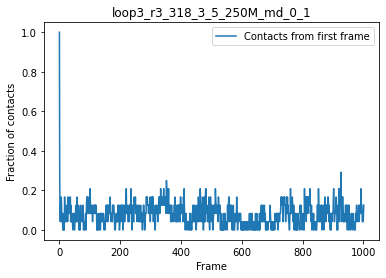

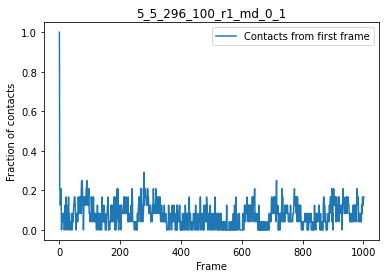

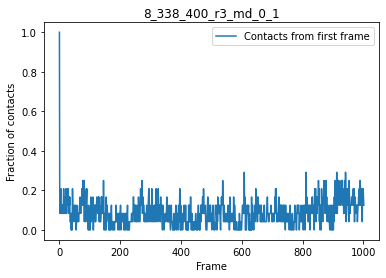

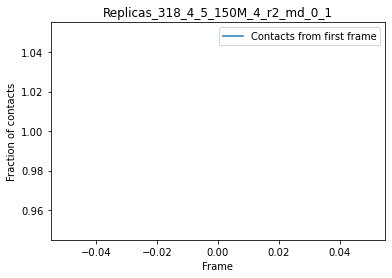

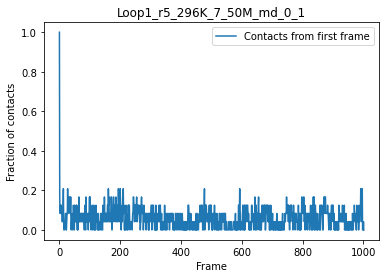

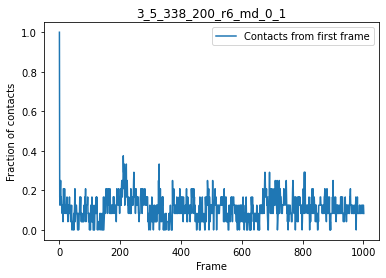

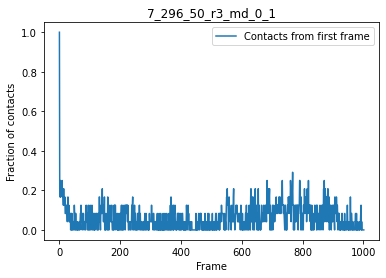

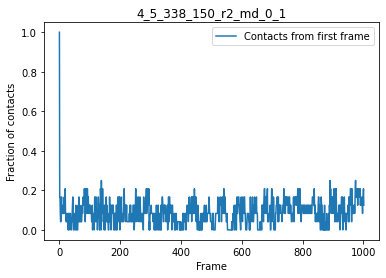

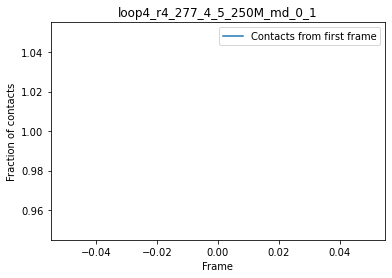

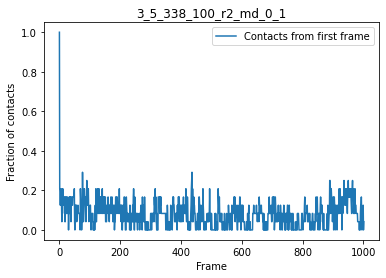

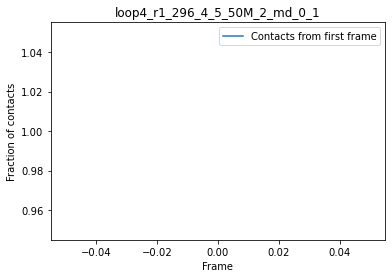

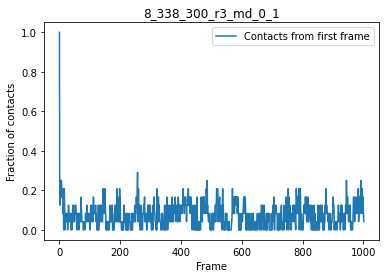

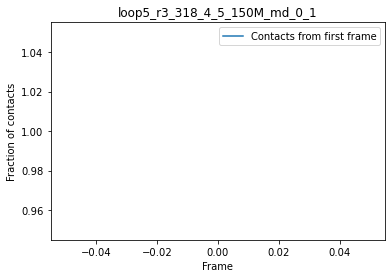

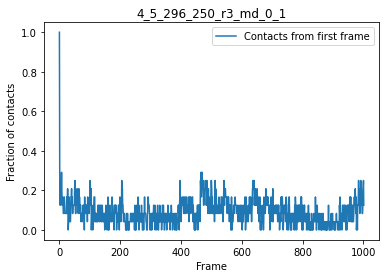

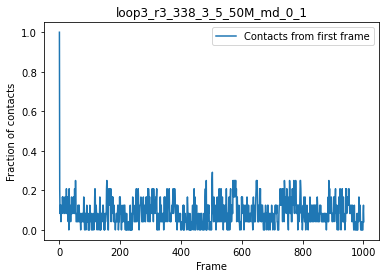

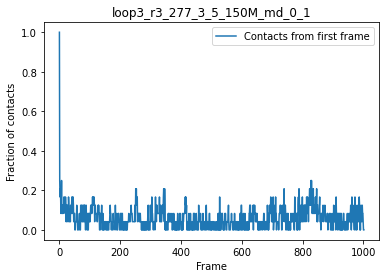

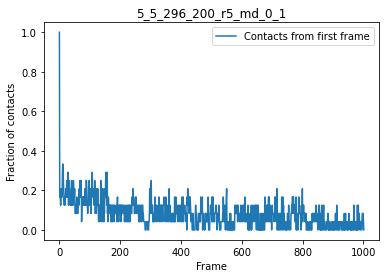

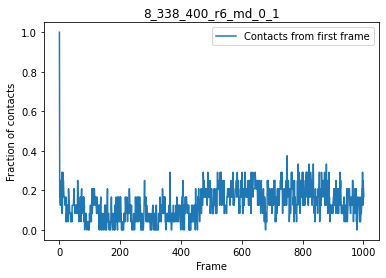

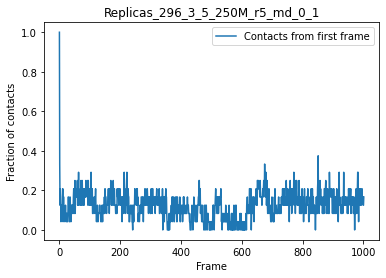

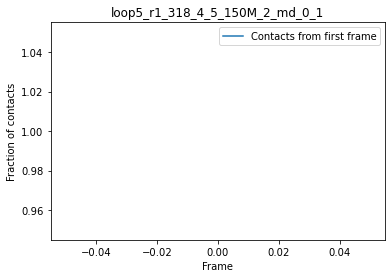

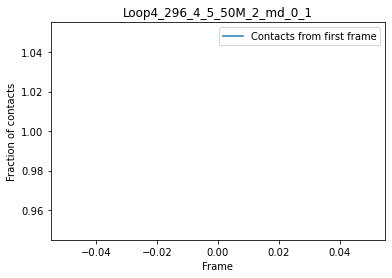

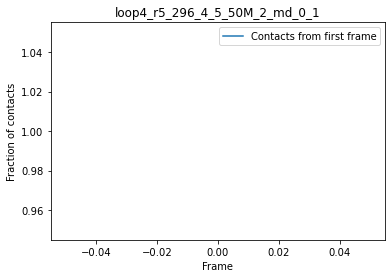

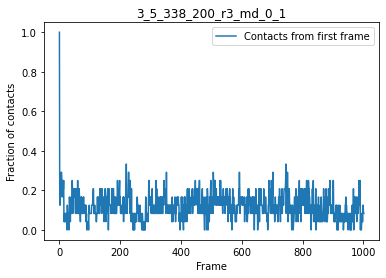

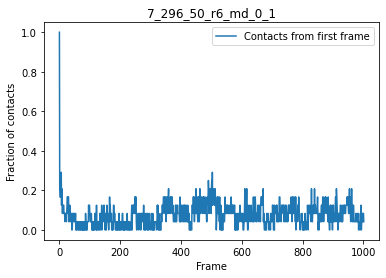

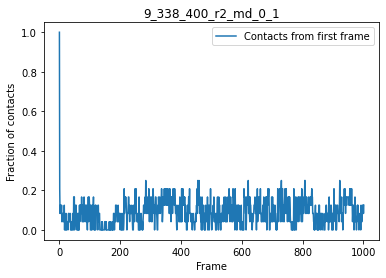

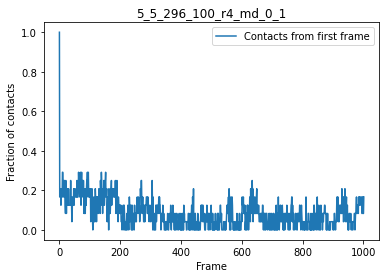

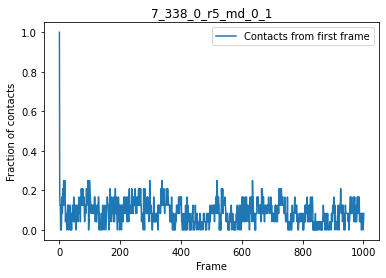

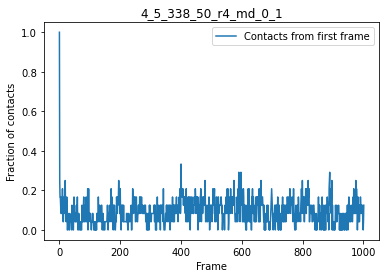

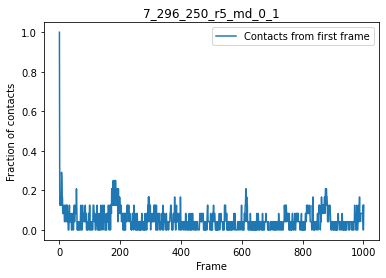

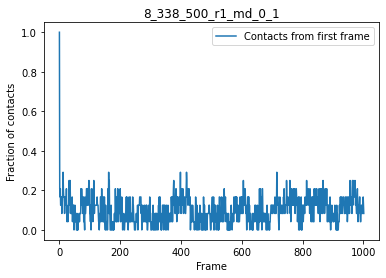

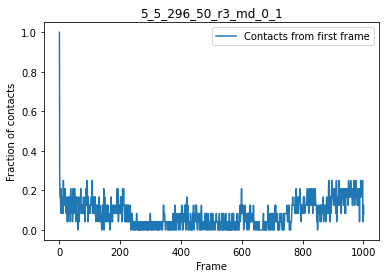

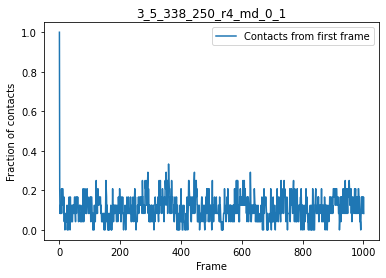

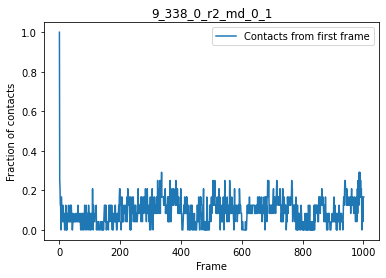

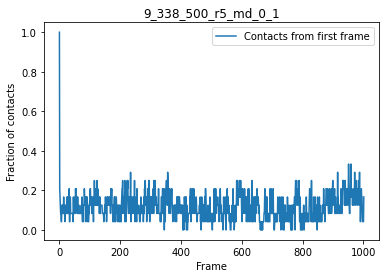

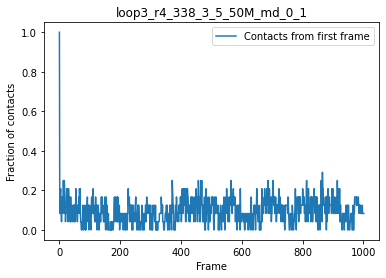

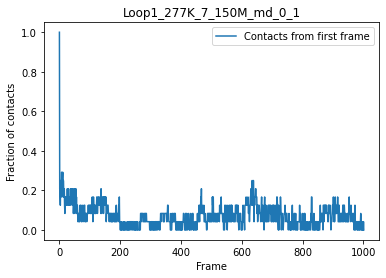

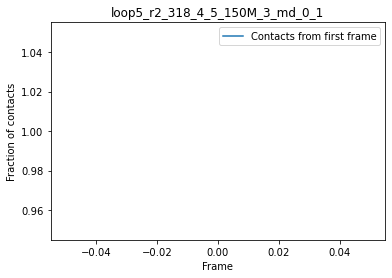

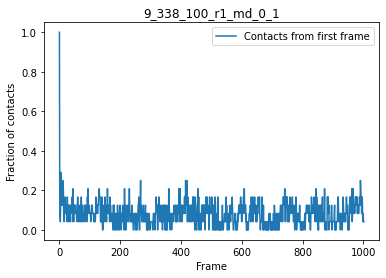

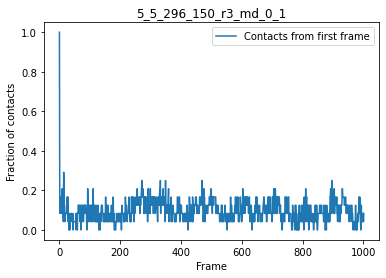

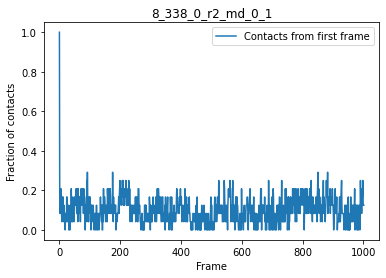

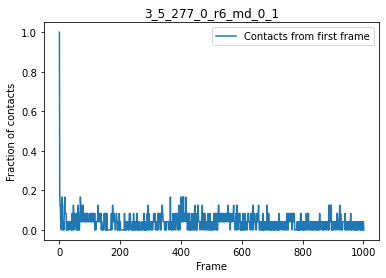

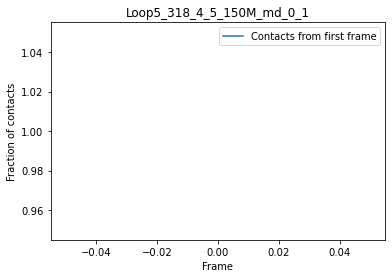

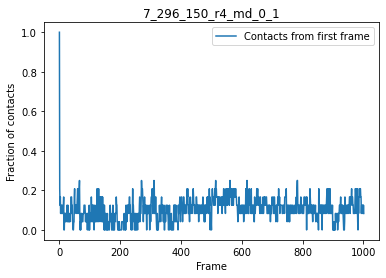

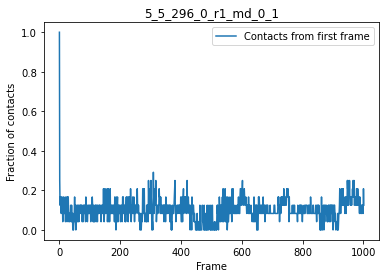

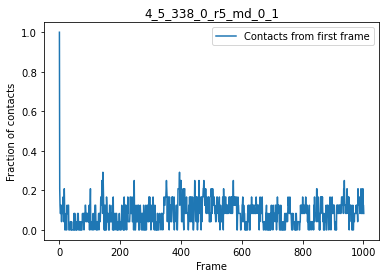

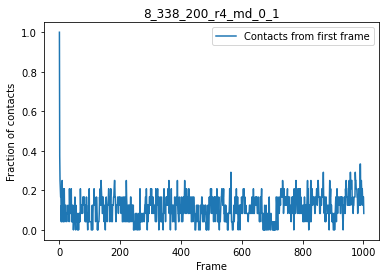

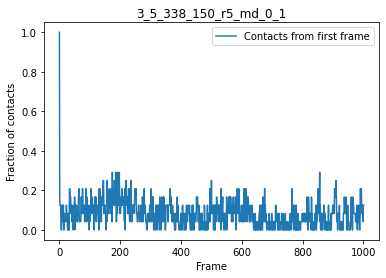

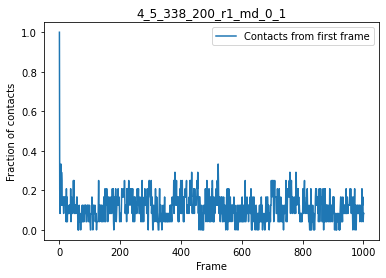

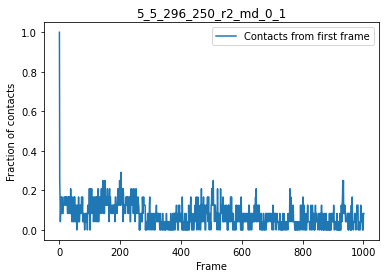

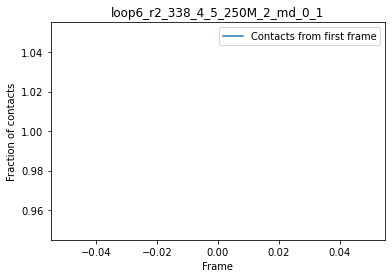

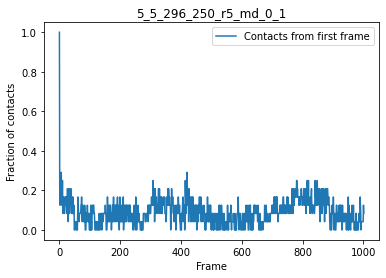

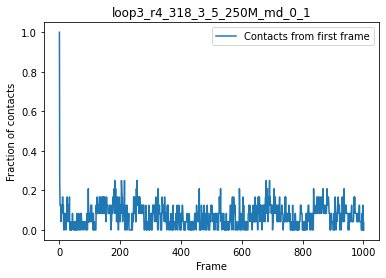

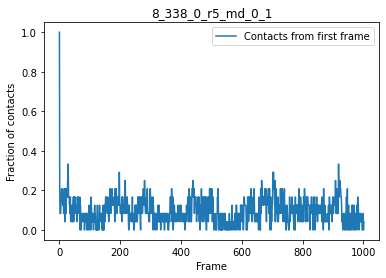

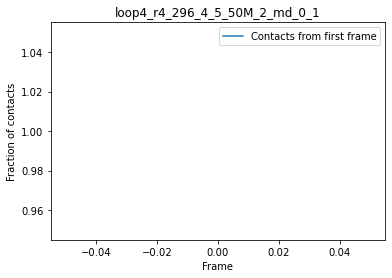

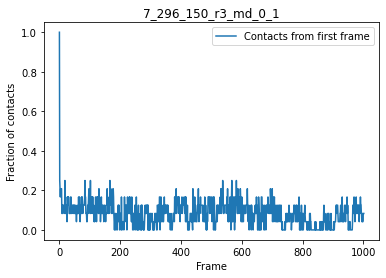

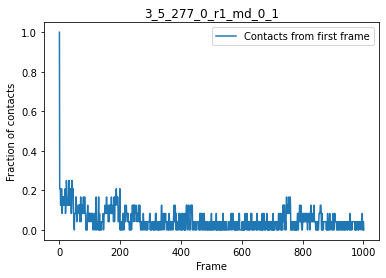

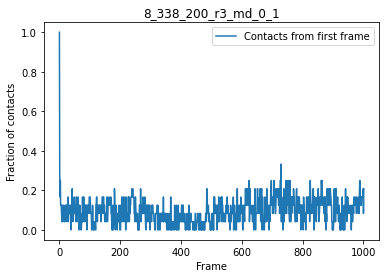

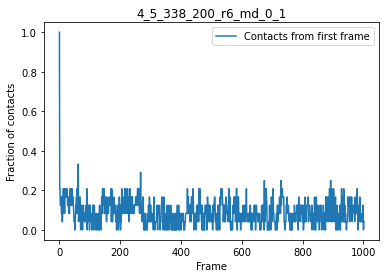

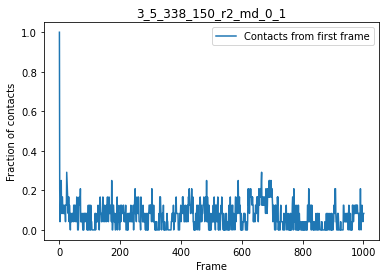

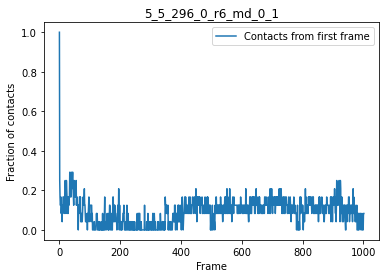

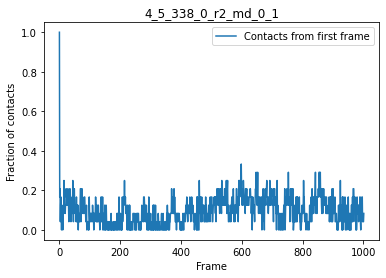

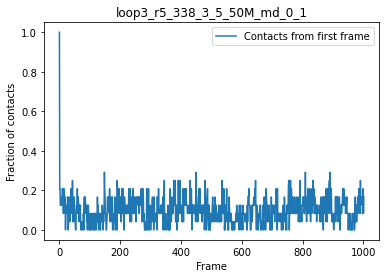

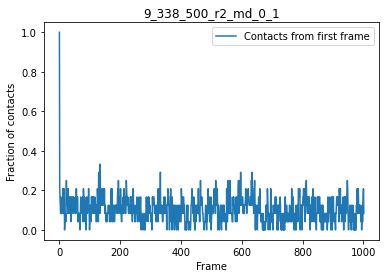

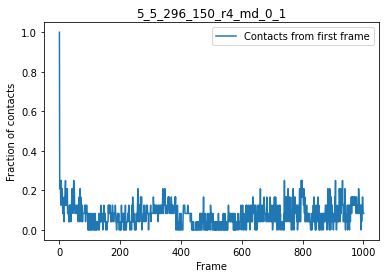

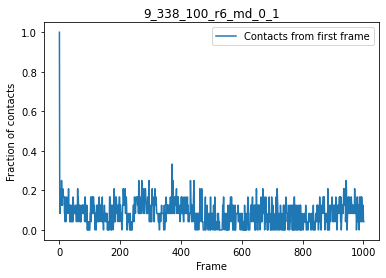

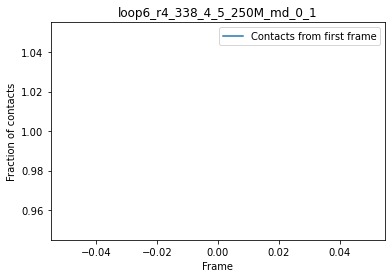

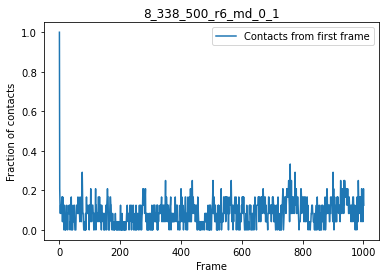

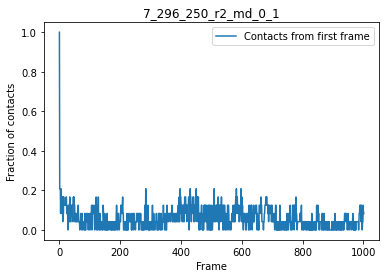

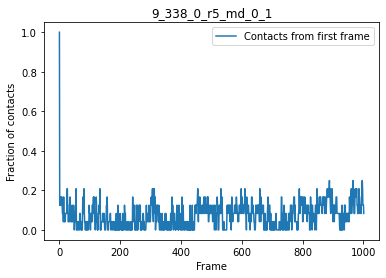

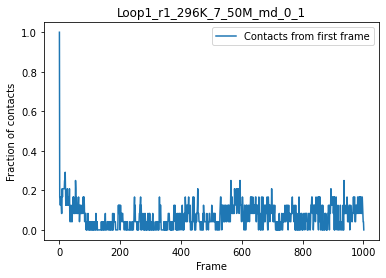

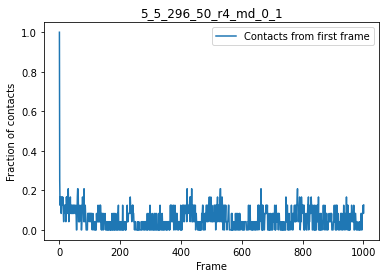

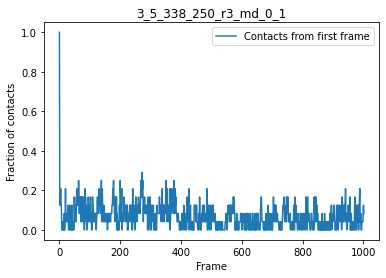

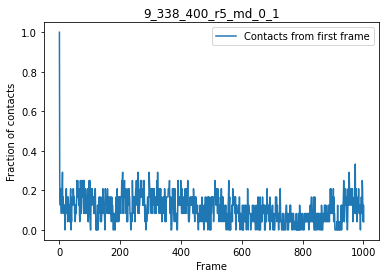

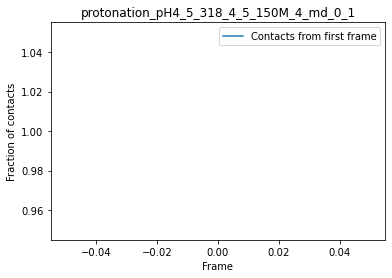

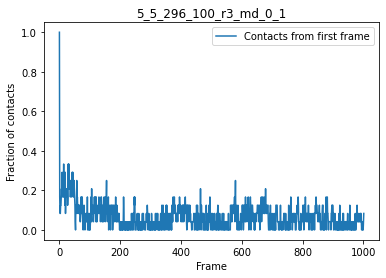

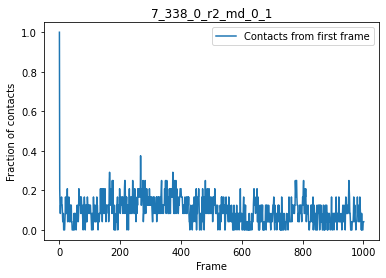

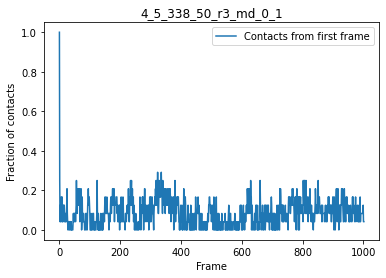

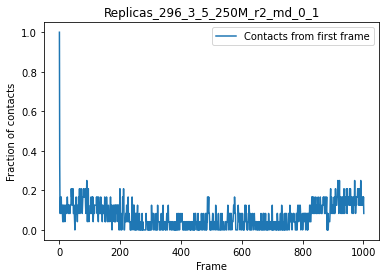

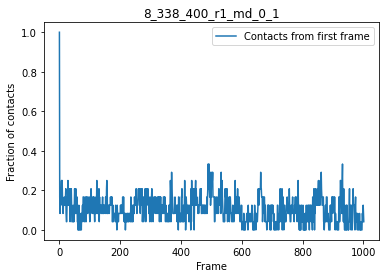

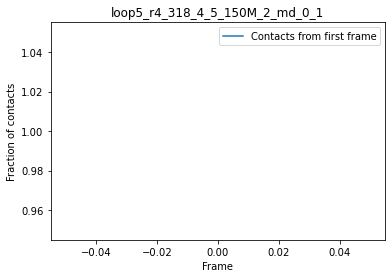

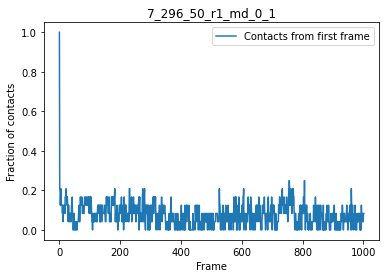

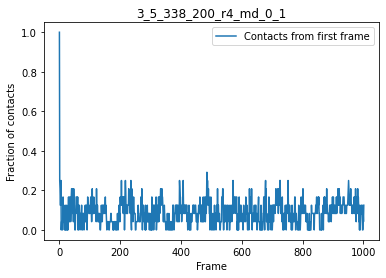

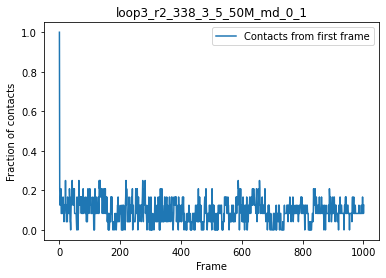

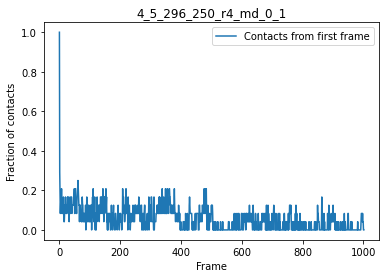

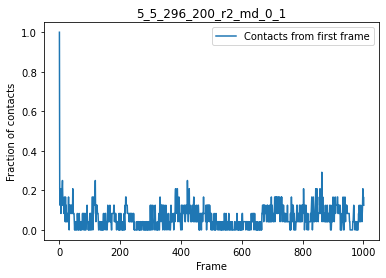

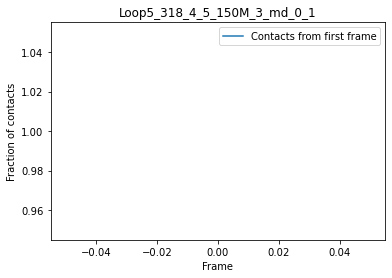

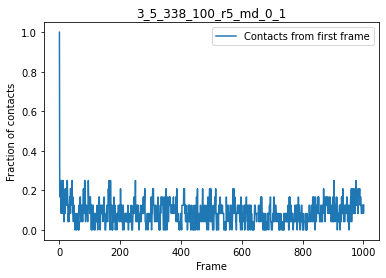

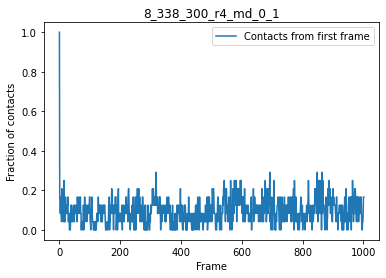

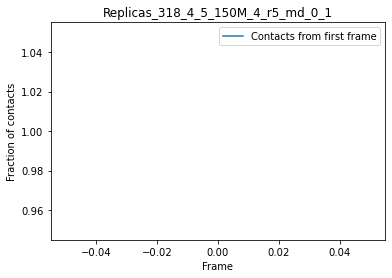

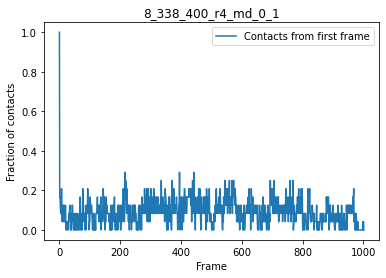

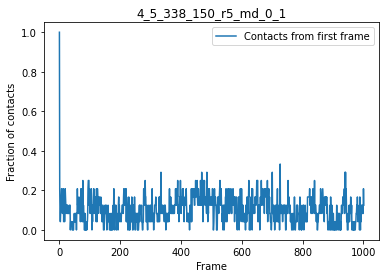

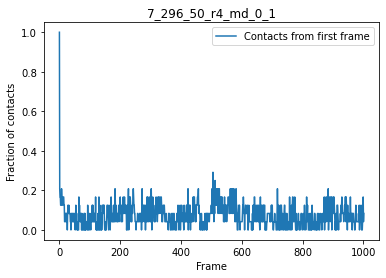

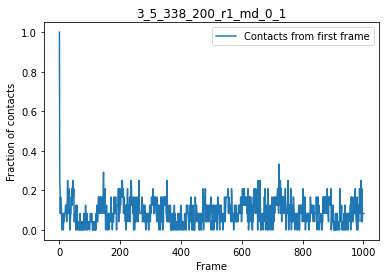

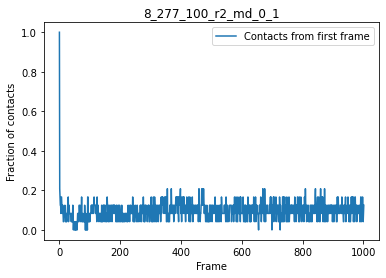

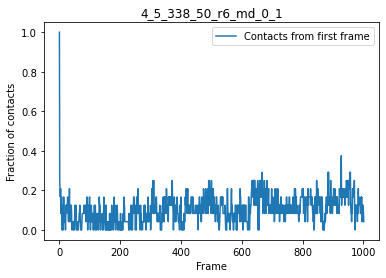

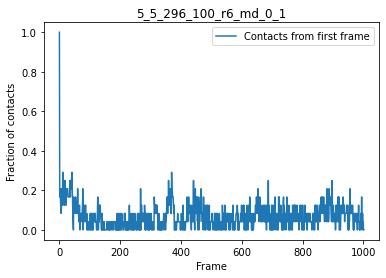

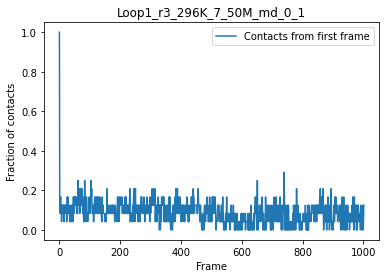

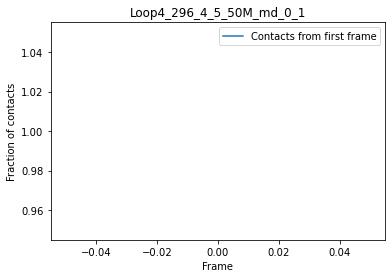

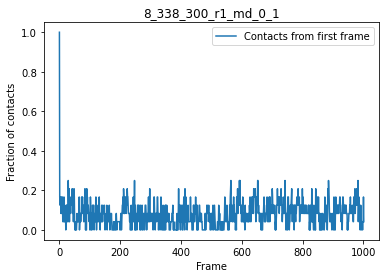

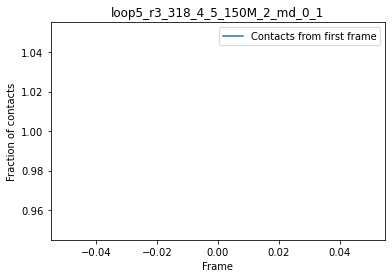

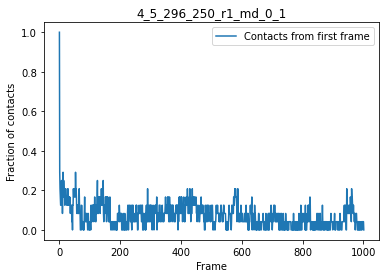

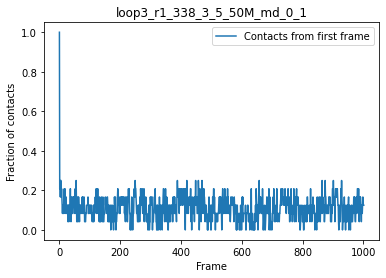

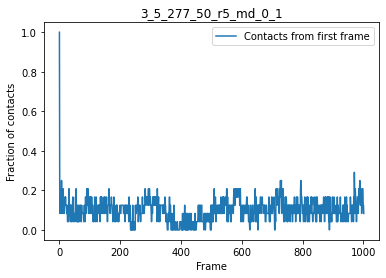

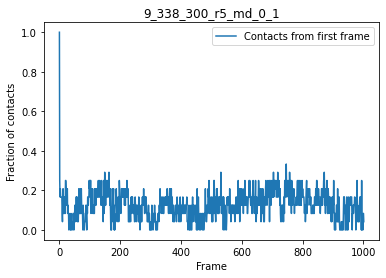

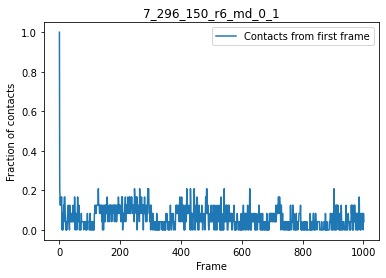

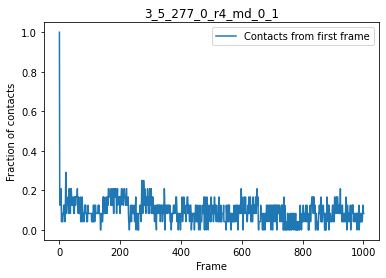

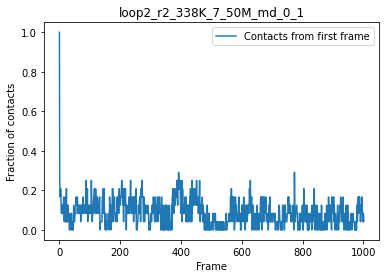

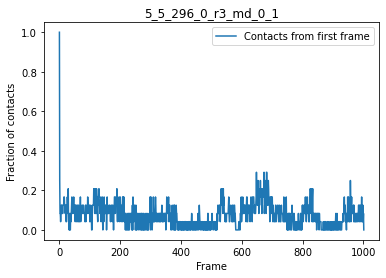

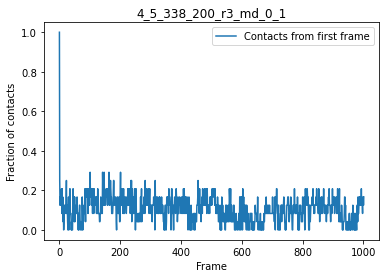

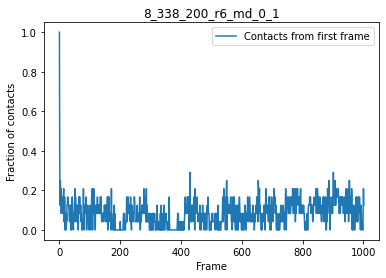

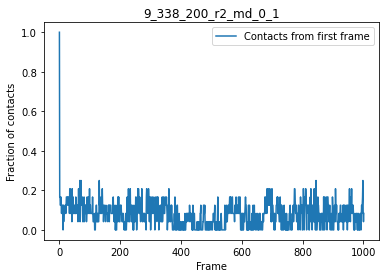

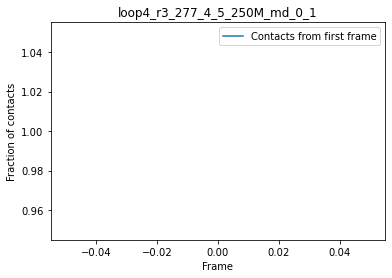

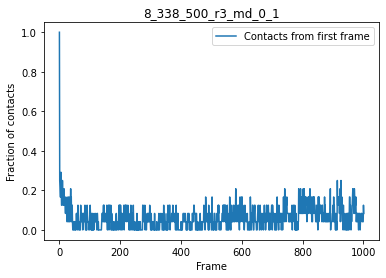

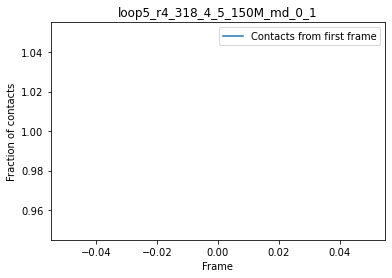

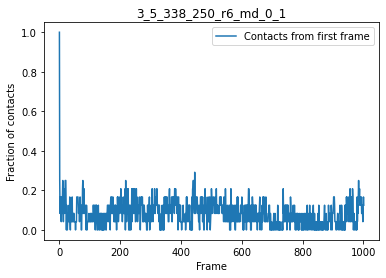

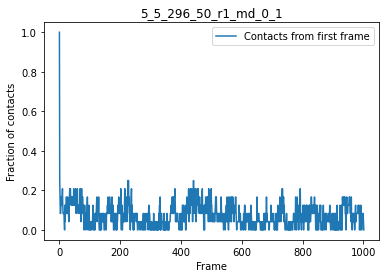

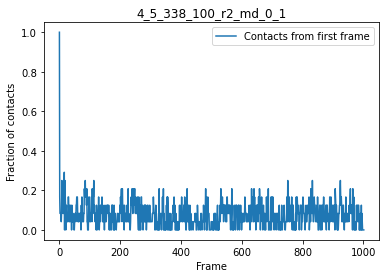

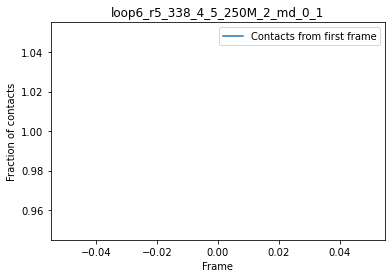

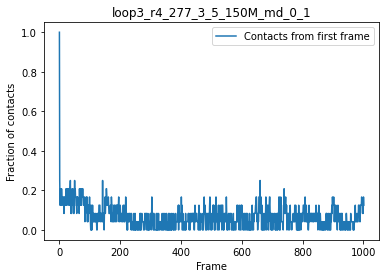

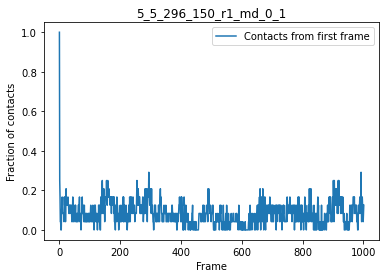

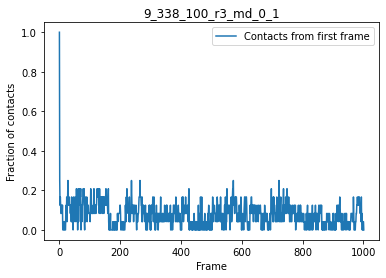

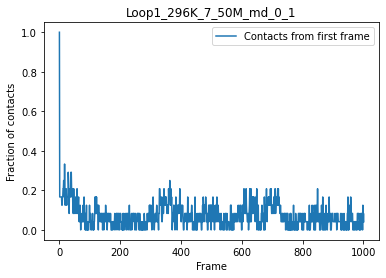

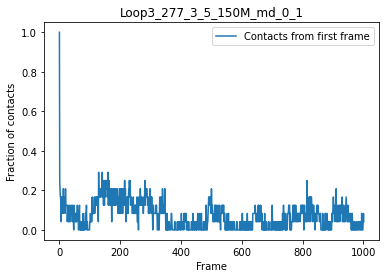

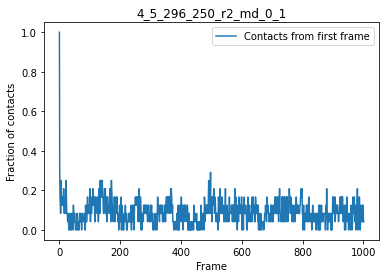

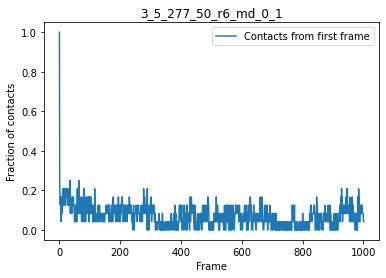

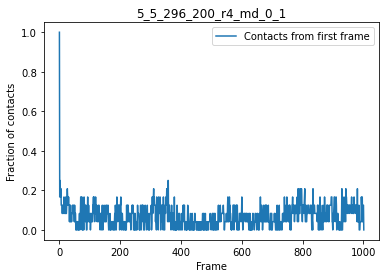

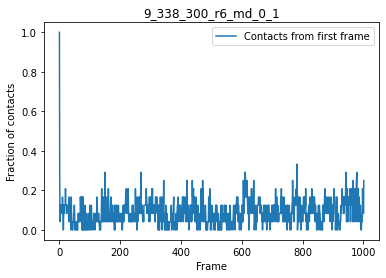

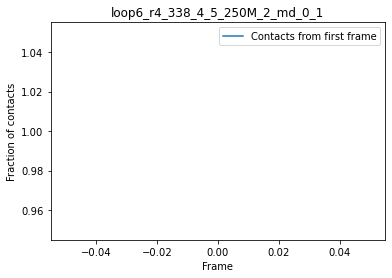

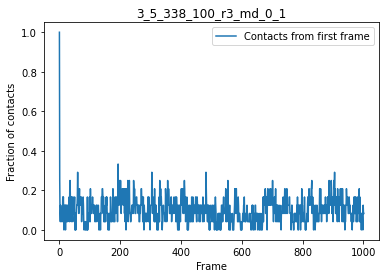

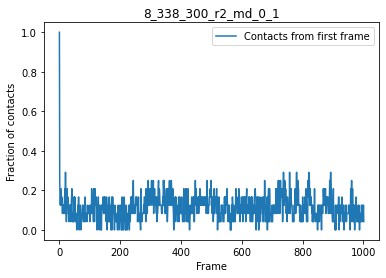

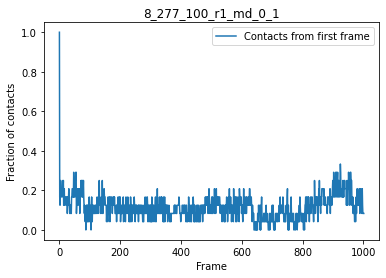

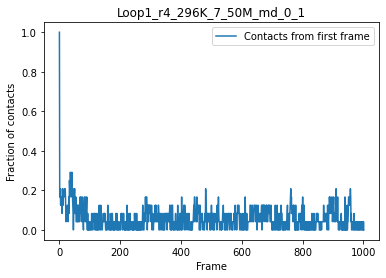

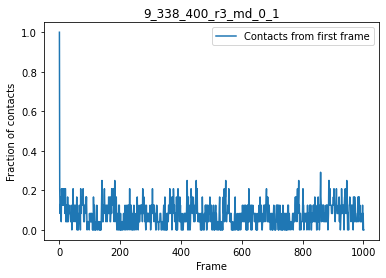

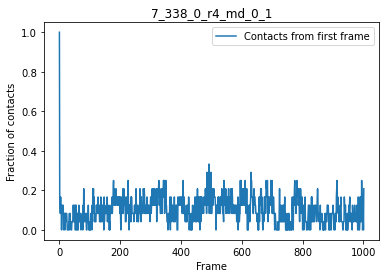

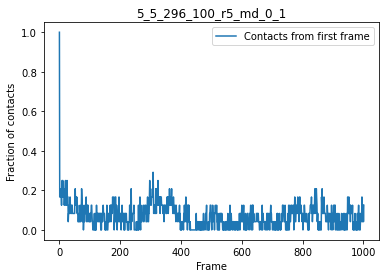

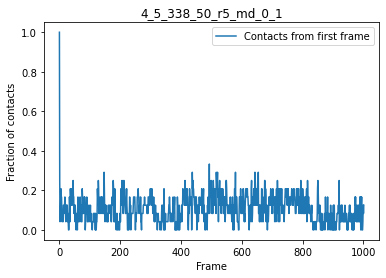

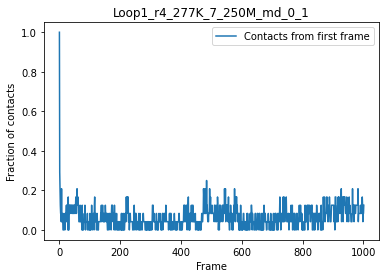

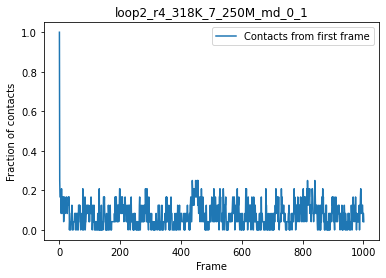

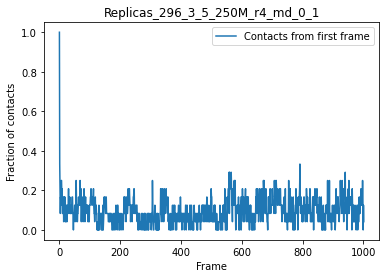

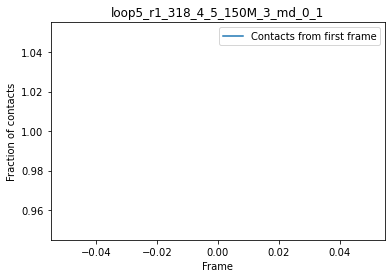

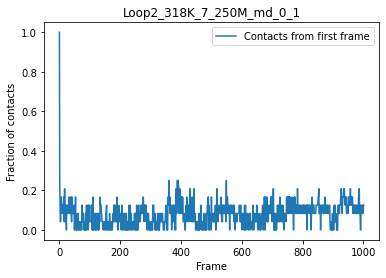

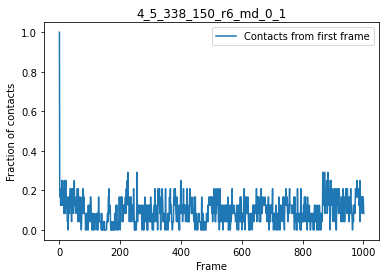

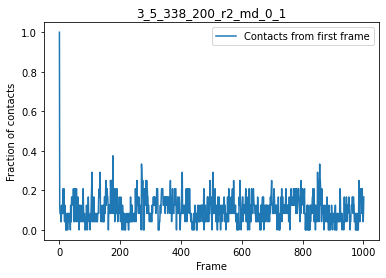

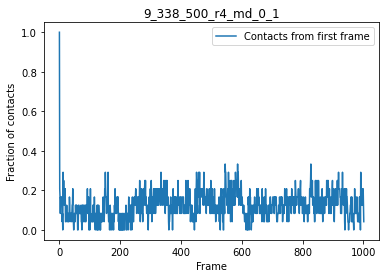

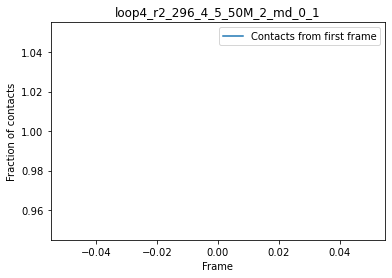

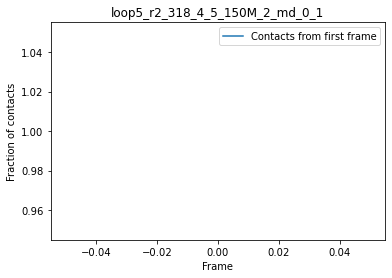

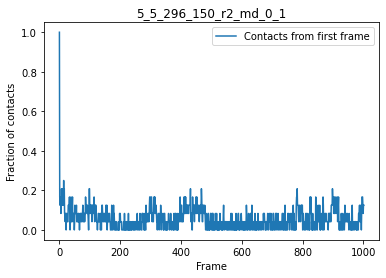

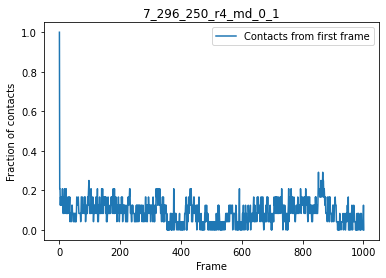

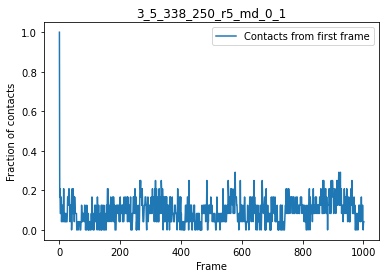

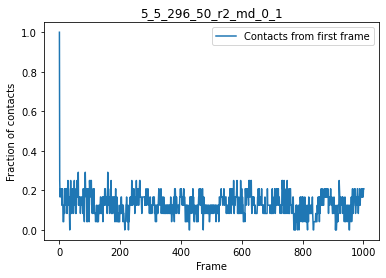

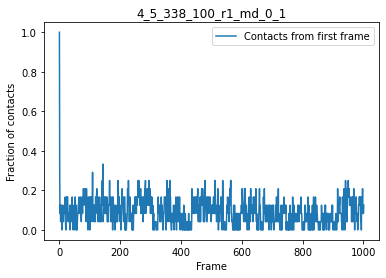

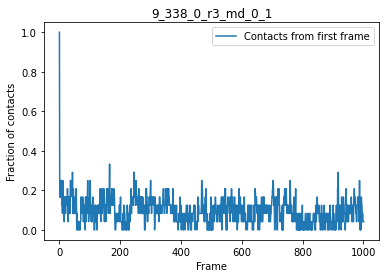

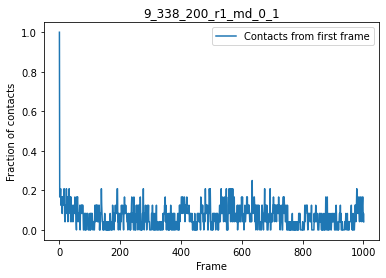

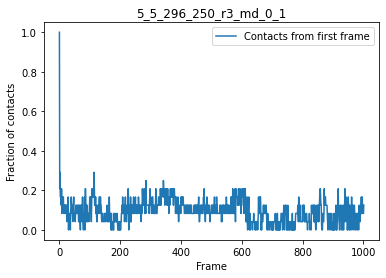

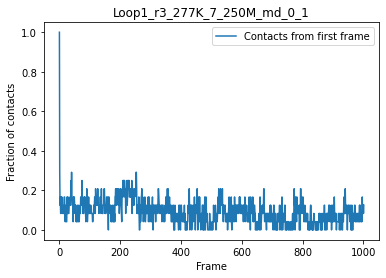

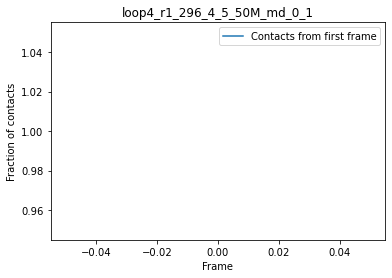

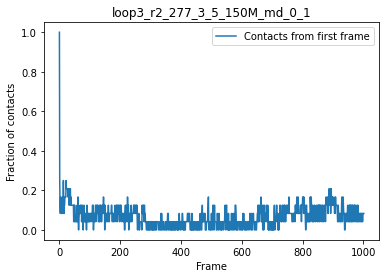

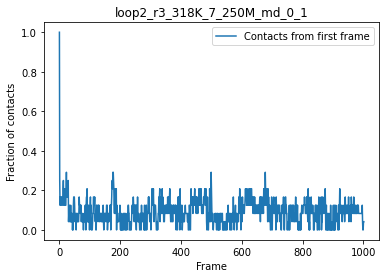

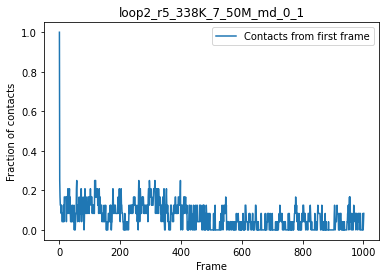

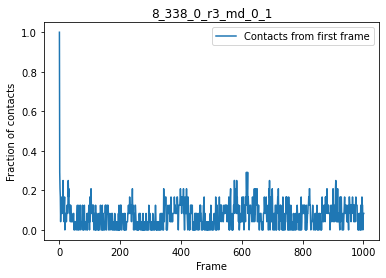

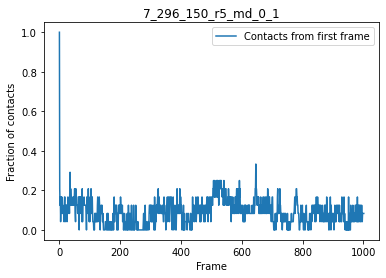

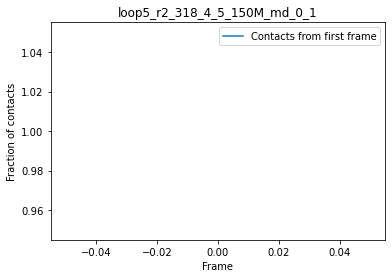

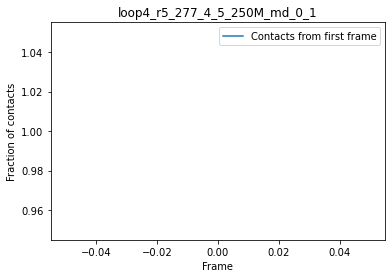

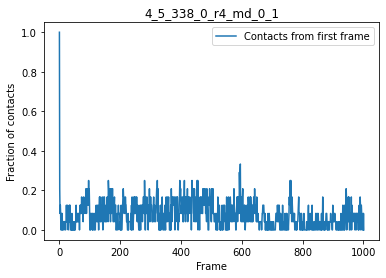

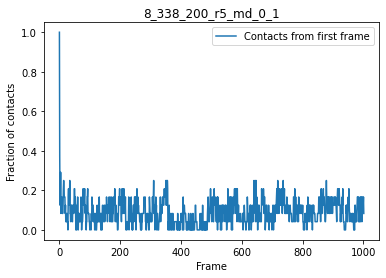

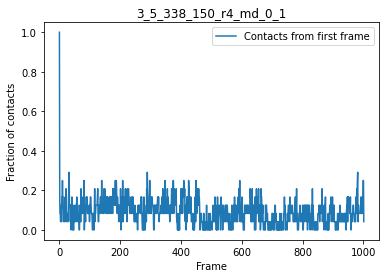

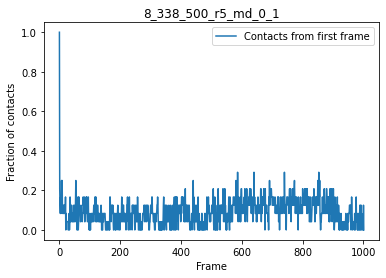

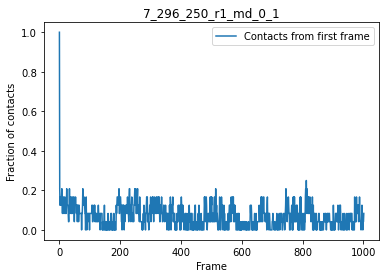

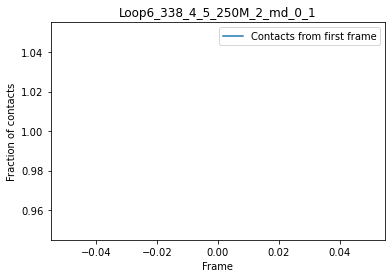

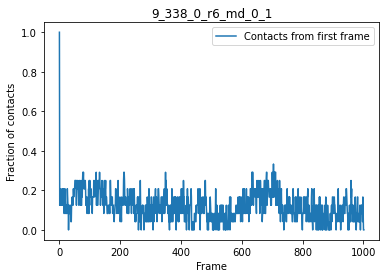

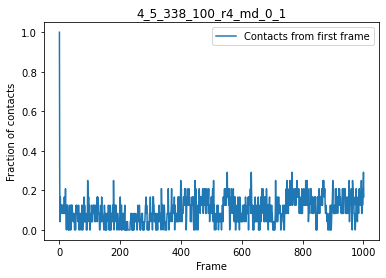

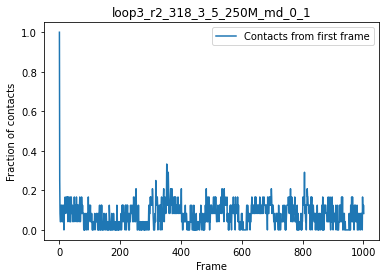

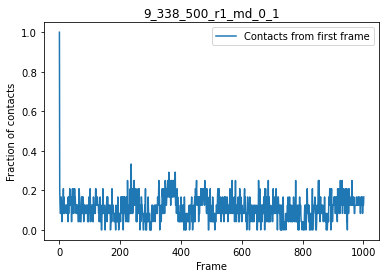

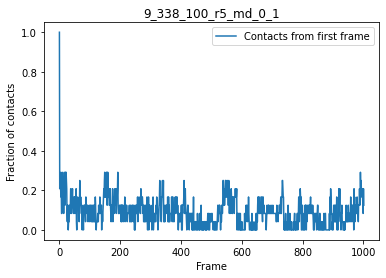

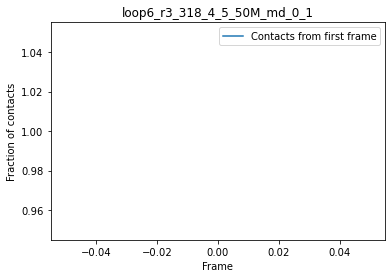

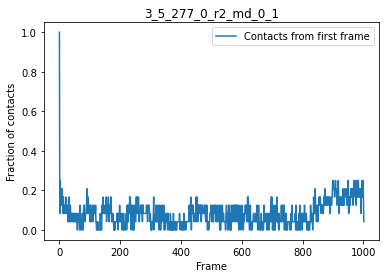

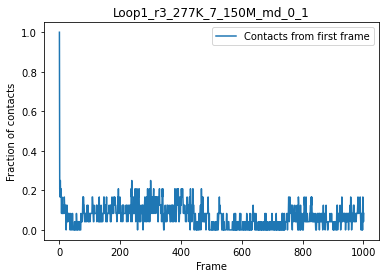

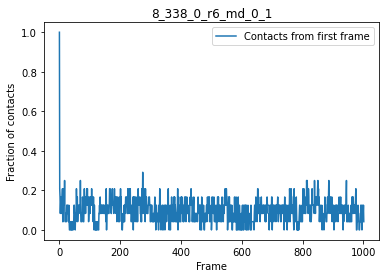

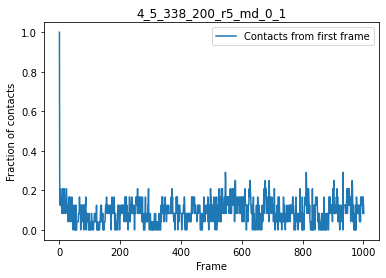

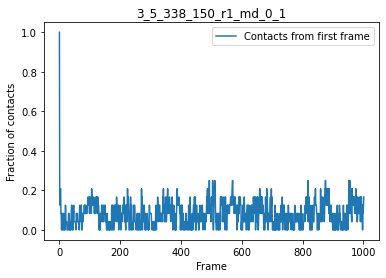

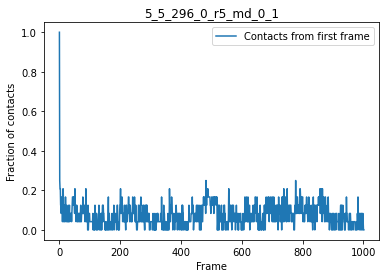

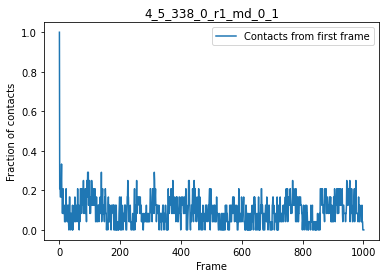

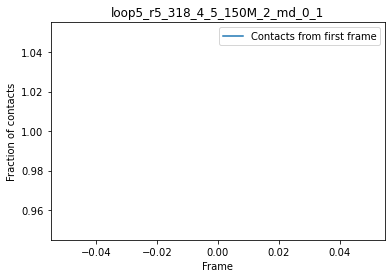

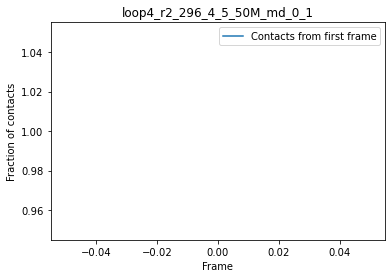

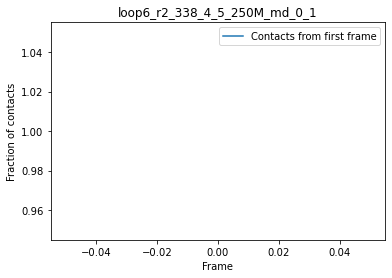

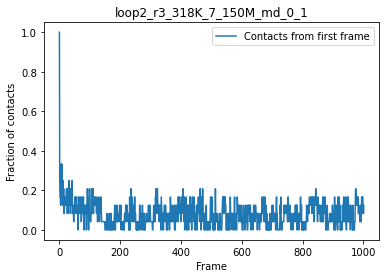

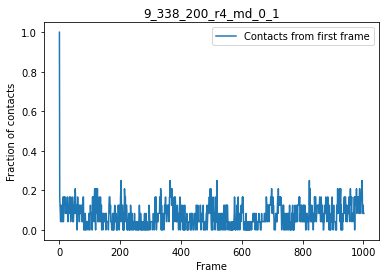

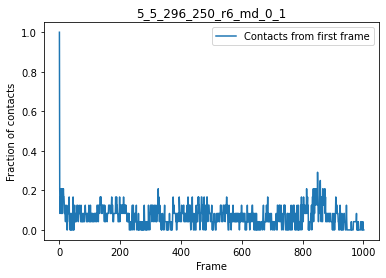

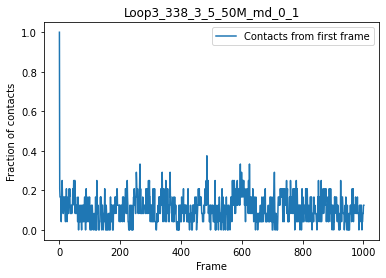

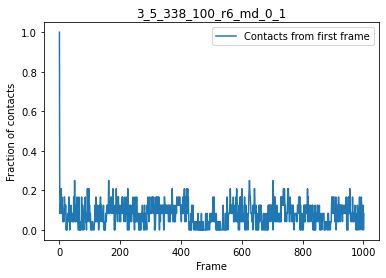

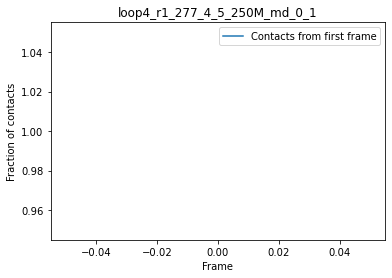

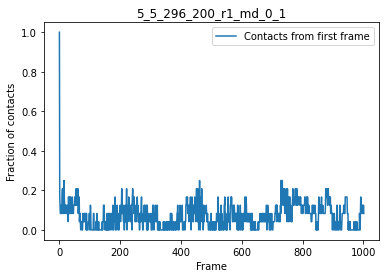

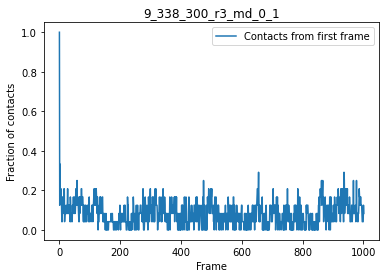

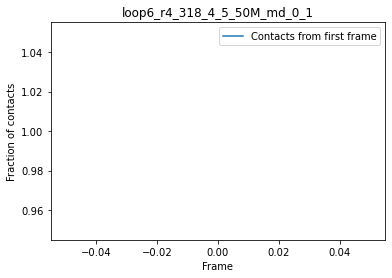

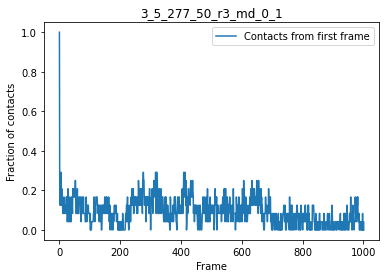

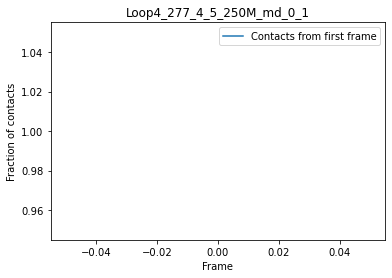

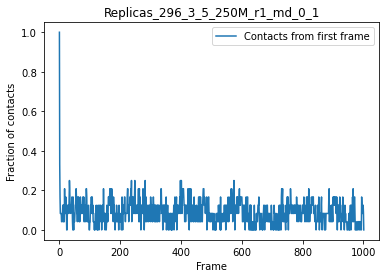

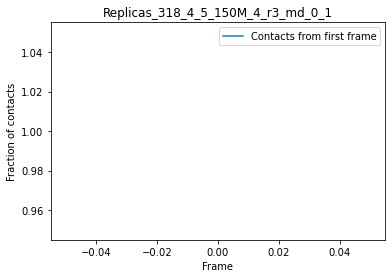

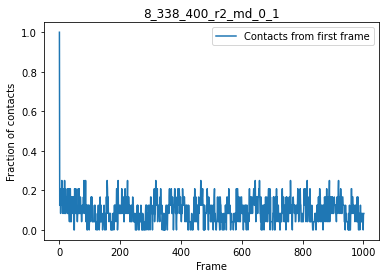

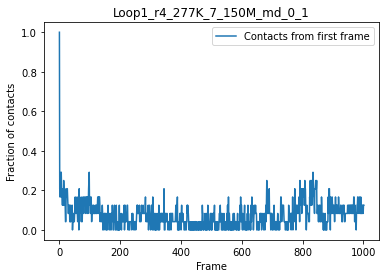

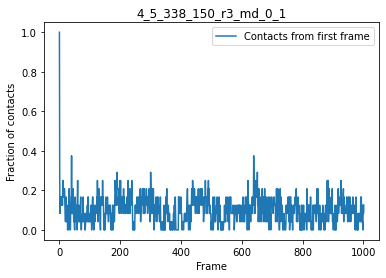

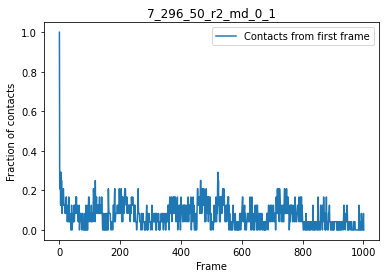

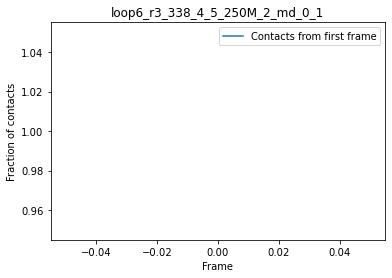

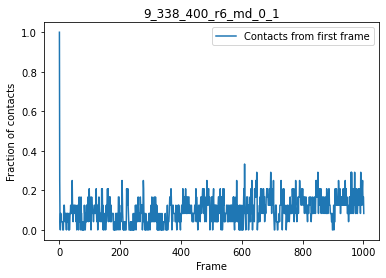

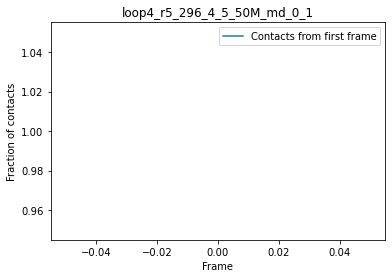

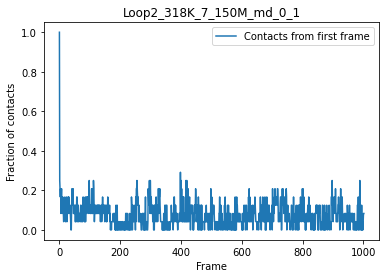

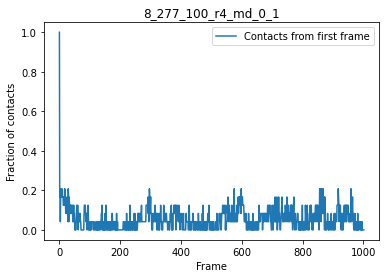

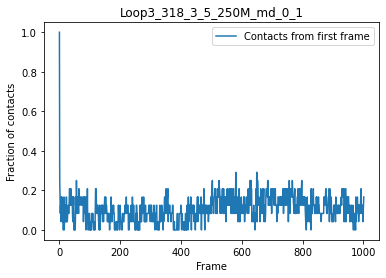

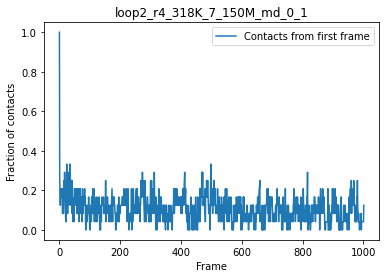

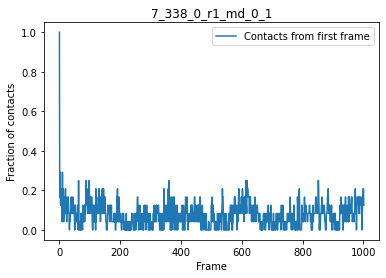

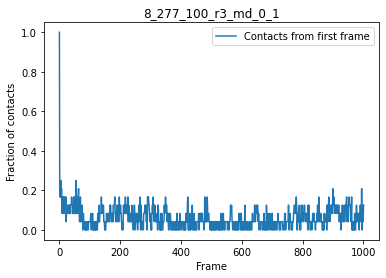

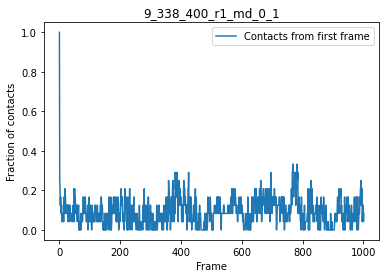

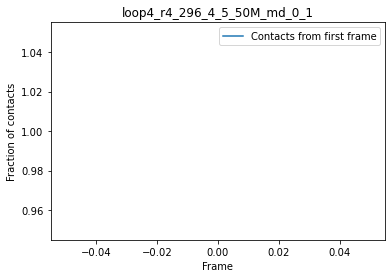

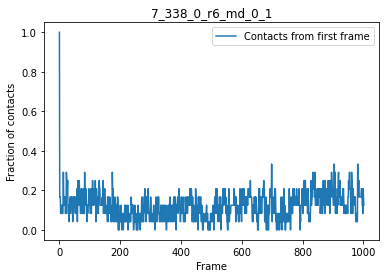

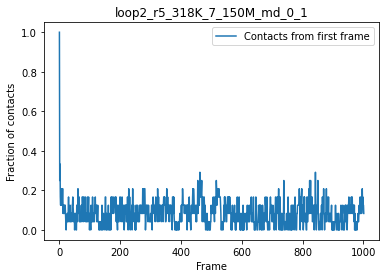

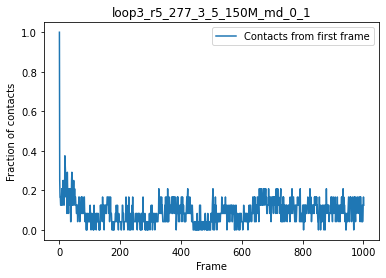

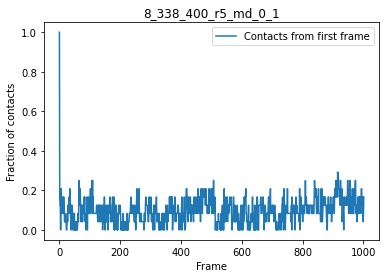

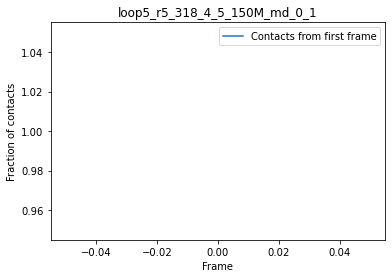

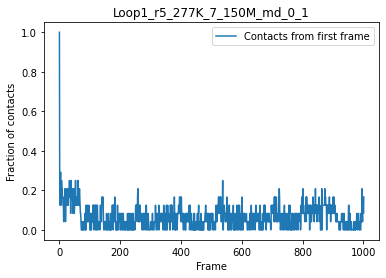

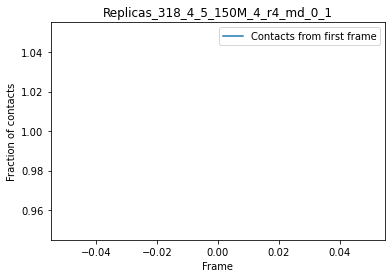

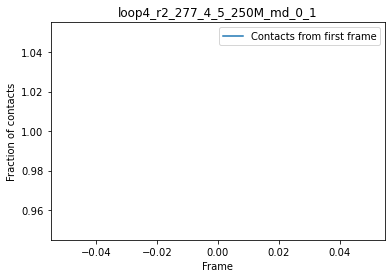

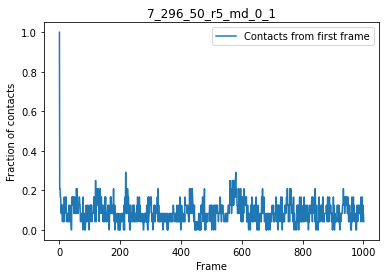

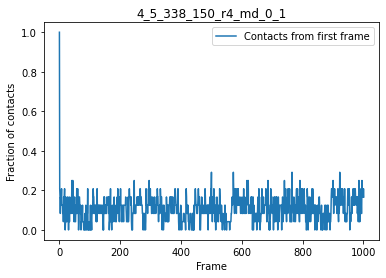

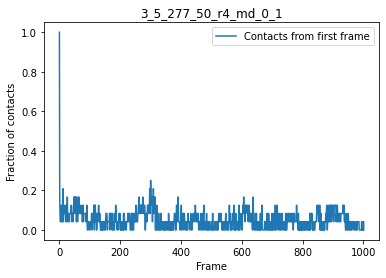

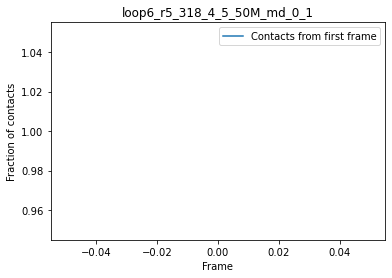

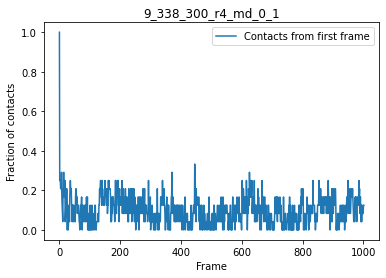

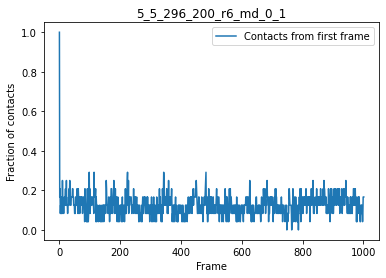

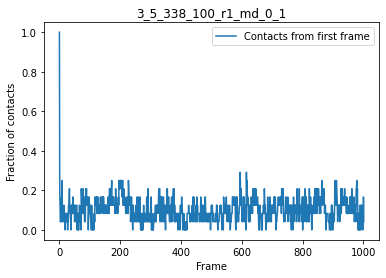

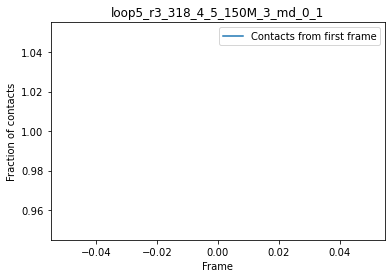

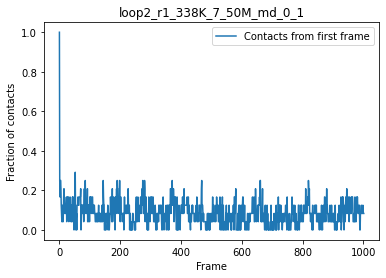

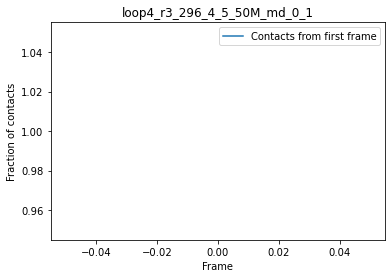

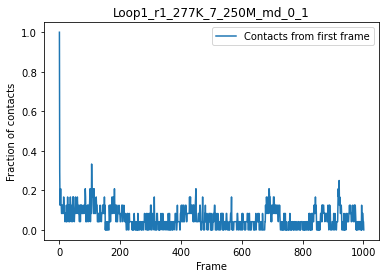

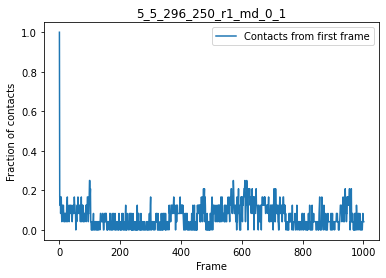

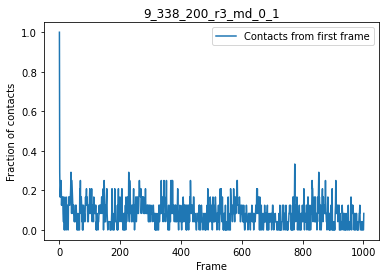

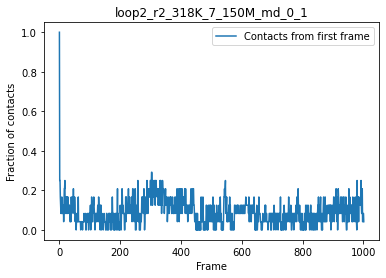

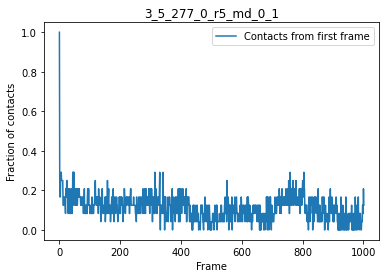

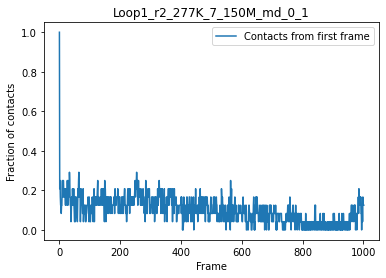

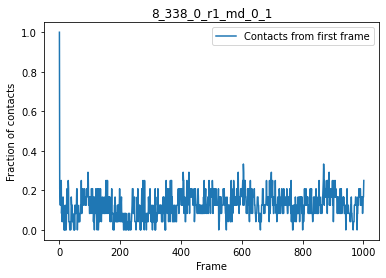

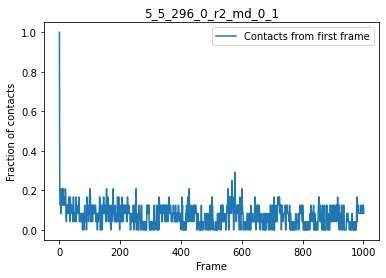

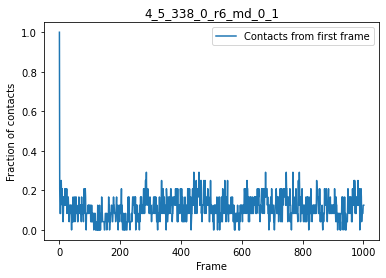

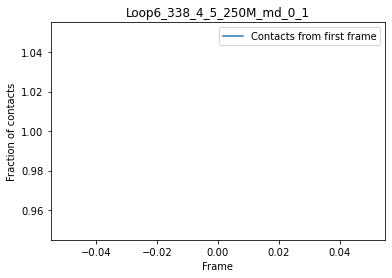

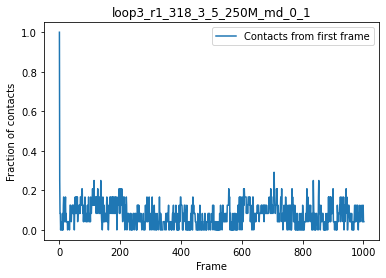

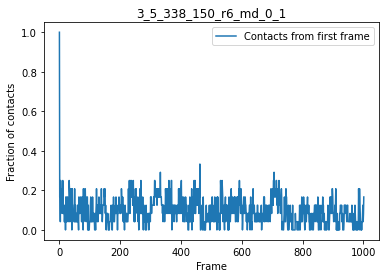

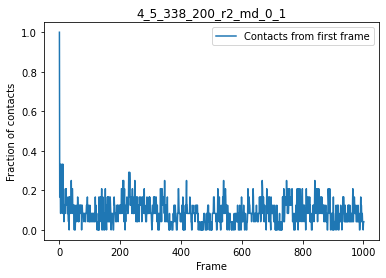

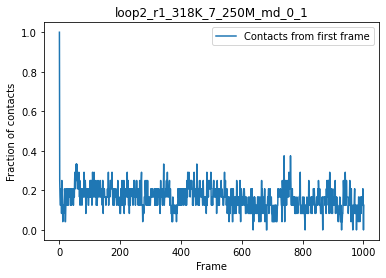

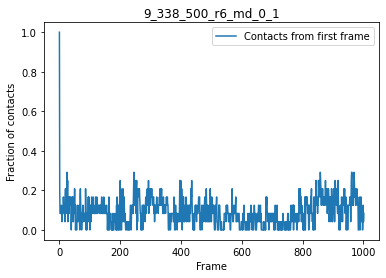

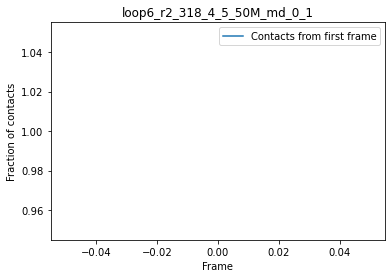

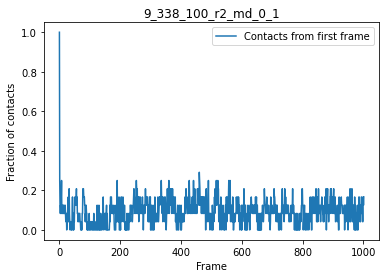

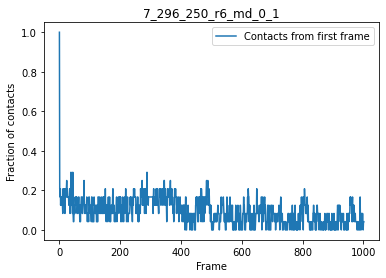

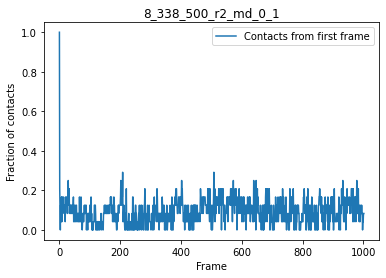

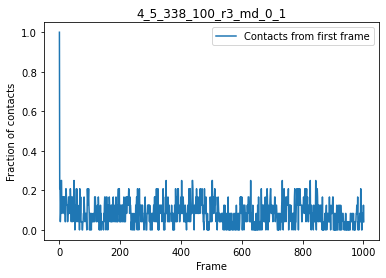

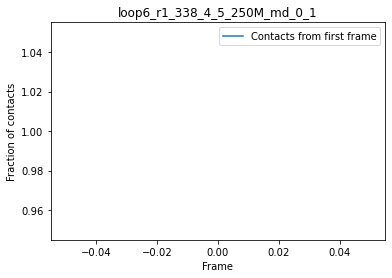

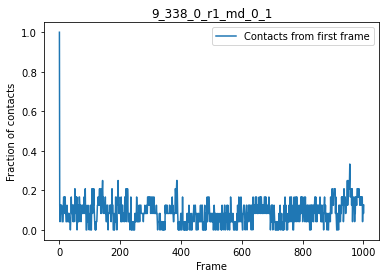

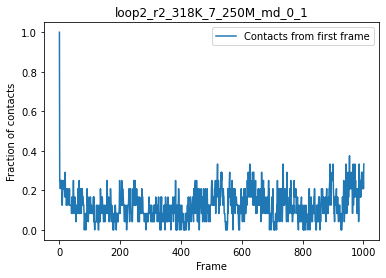

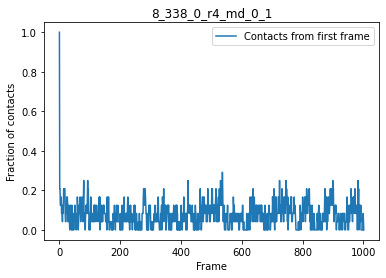

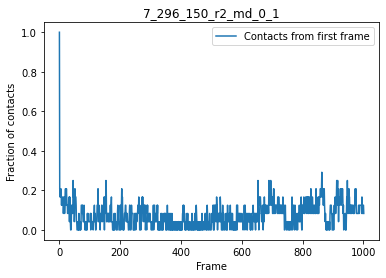

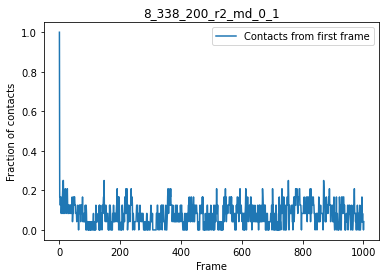

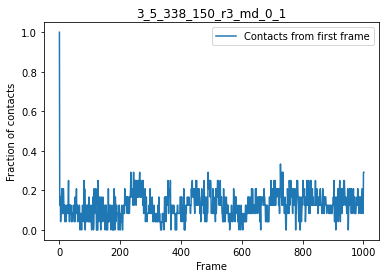

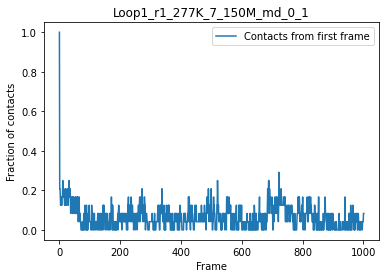

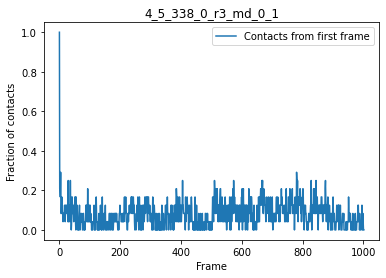

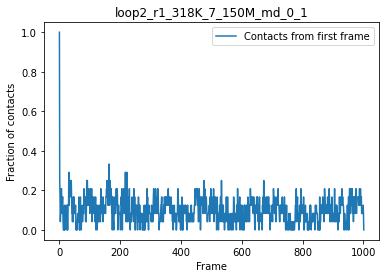

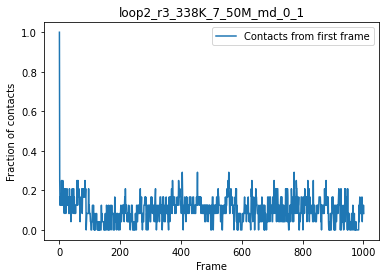

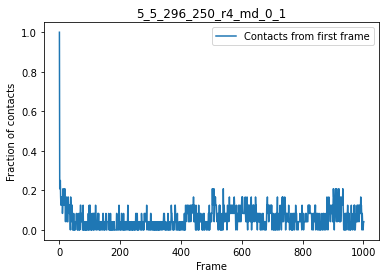

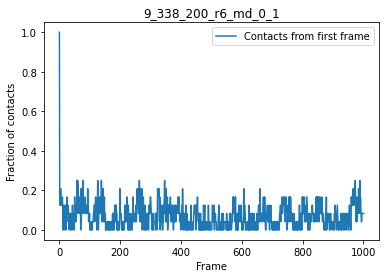

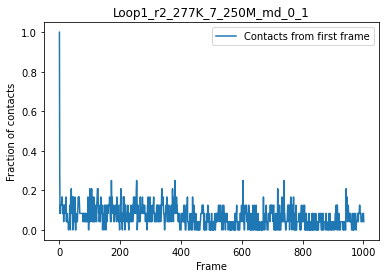

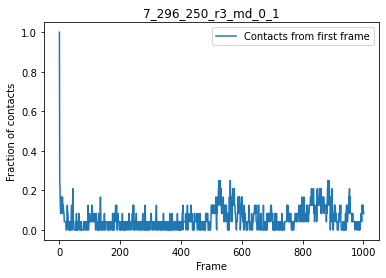

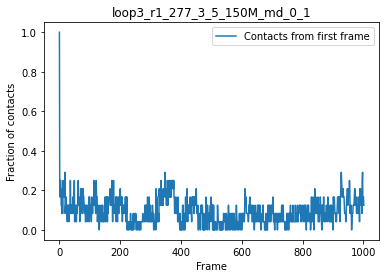

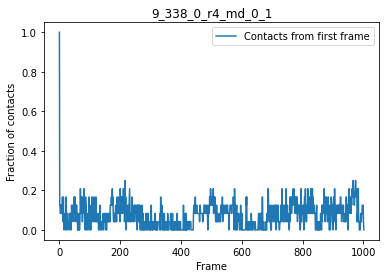

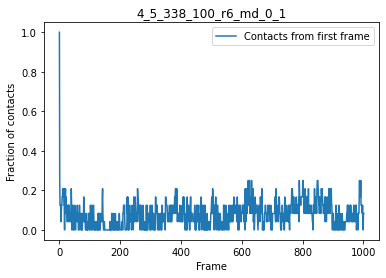

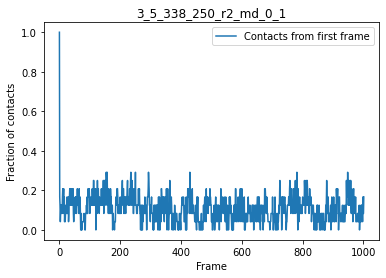

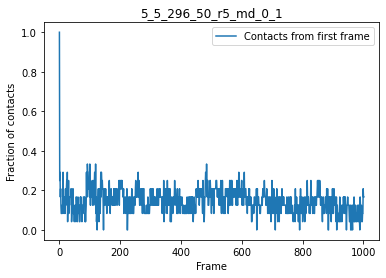

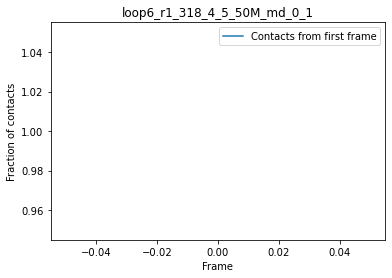

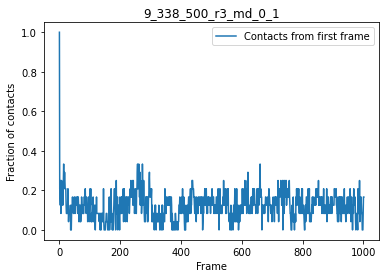

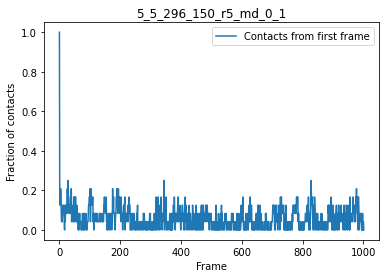

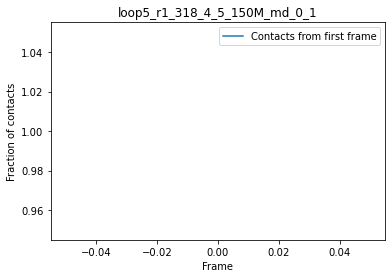

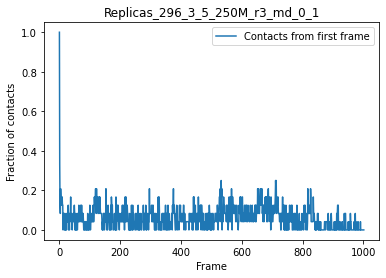

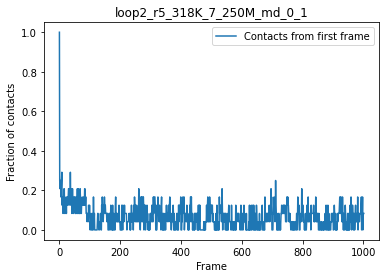

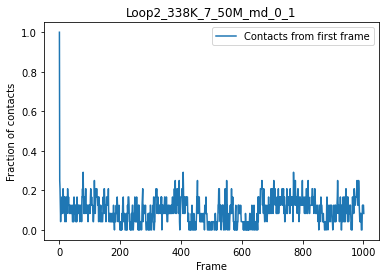

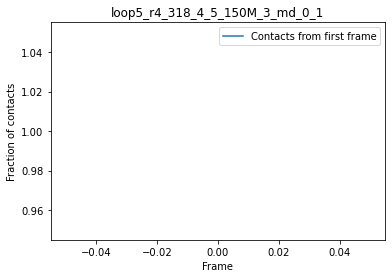

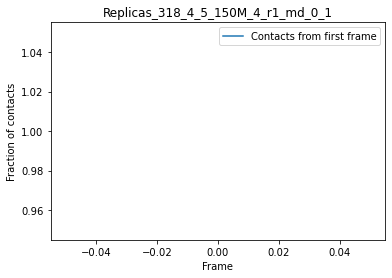

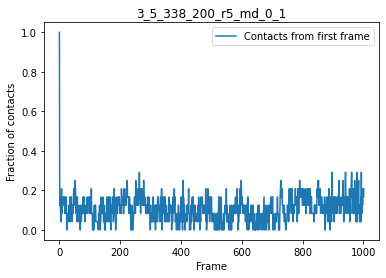

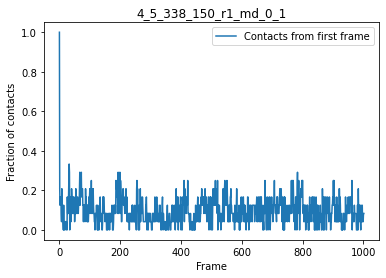

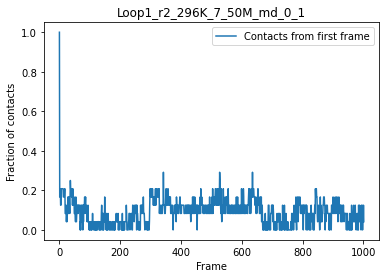

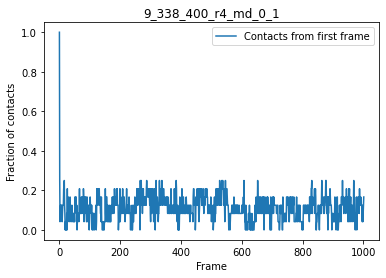

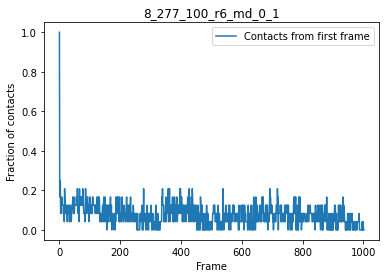

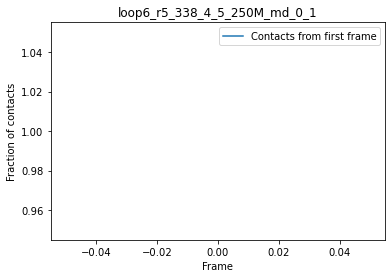

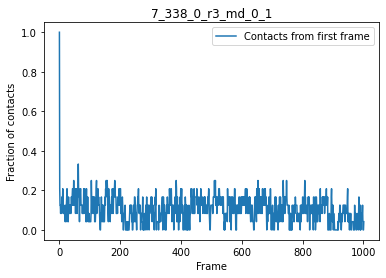

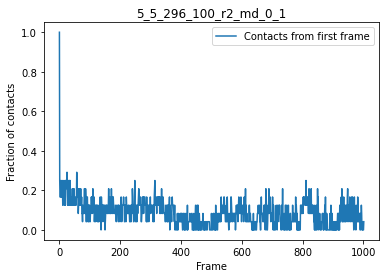

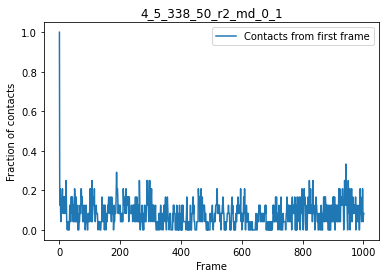

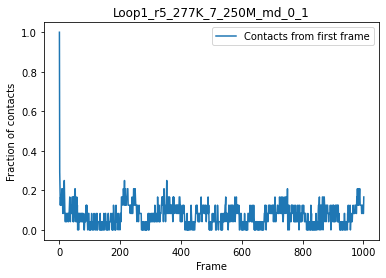

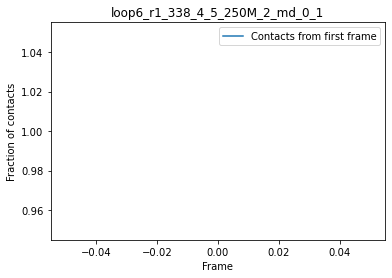

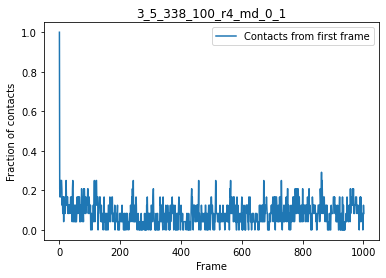

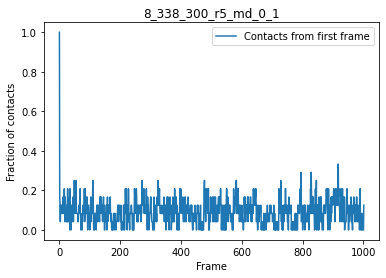

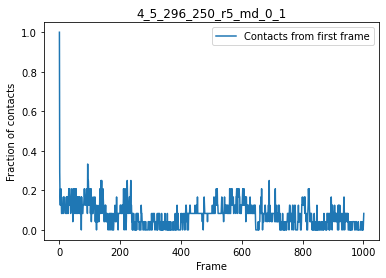

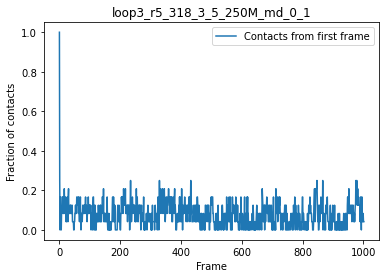

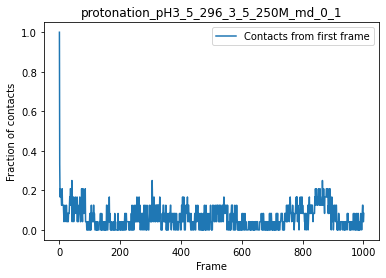

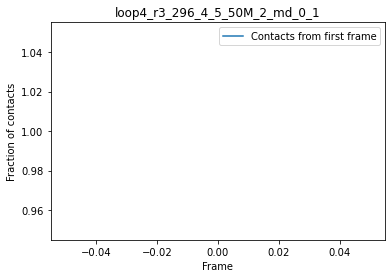

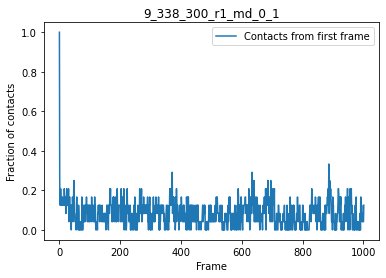

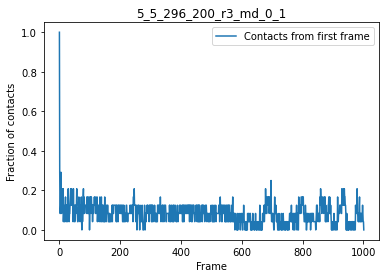

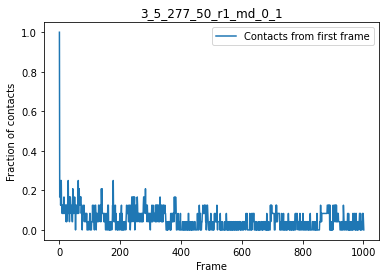

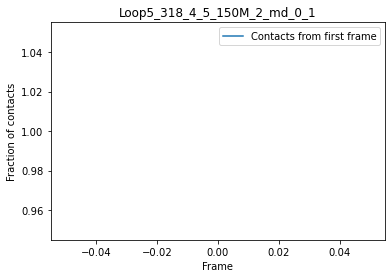

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
import pandas as pd
import os


#Change to the five DCD files' directory

os.chdir('/Users/wintermute/Library/CloudStorage/GoogleDrive-wintermute.backup@gmail.com/My Drive/MacbookPro/GoogleDrive/UCL/PaulGroup/MolecularDynamics/Gromacs/FabA33/DataAnalysisAll200323/NativeContacts250423/NativeContact54runs140623/54DCD140623')

# define directory
path = os.getcwd()

# read pdb
pdb = "Fab.pdb"

# create a list for saving average native contacts
data = []
cols = ['Condition', 'Average native contact (last 50ns)']

# loop over every dcd file in the directory
for file in os.listdir(path):
    
    # select the file that ends with .dcd
    # reference: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
    if file.endswith(".dcd"):

        # read dcd trajecotry
        dcd = file
        u = mda.Universe(pdb,dcd)

        # get the filename without the extension
        filename = os.path.splitext(file)[0]

        # crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
        # OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
        # problem before using this for real work.

        #reference: https://docs.mdanalysis.org/1.0.1/documentation_pages/analysis/contacts.html

        # As the comments above, perhaps need to double check whether use this version of defination of salt bridges

        # this defination doesn't work in this case

        sel_basic = "(resname ARG or resname LYS) and (name NH* NZ)"
        sel_acidic = "(resname ASP or resname GLU) and (name OE* OD*)"

        #the (acidic, basic) selections from u, which are assigned from the first frame 

        basic = u.select_atoms(sel_basic)
        acidic = u.select_atoms(sel_acidic)


        ca2 = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic),
                        radius=4.5,
                        method='radius_cut').run()

        ca2_df = pd.DataFrame(ca2.timeseries,
                      columns=['Frame', 'Contacts from first frame'])

        # print number of average contacts for each condition
        average_contacts = np.mean(ca2.timeseries[501:, 1])
        
        # append the values into a list first and then convert it to a dataframe
        # this will save a lot of performance time
        # reference: https://stackoverflow.com/questions/31674557/how-to-append-rows-in-a-pandas-dataframe-in-a-for-loop
        data.append([filename, average_contacts])

        #plot native contacts
        ca2_df.plot(x='Frame')
        plt.ylabel('Fraction of contacts')
        plt.title(filename)
        
        plt.savefig(filename + '.png')
        
        continue
    
    else:
        continue



In [51]:
df1 = pd.DataFrame(data, columns=cols)
df1.to_excel('54DCDTest140623.xlsx')